In [2]:
import os
import shutil
import tempfile
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib
import scipy.ndimage as ndi
import pandas as pd
import random
import shutil
import statistics
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from fastai.vision.all import *

from monai.losses import DiceCELoss,GeneralizedDiceFocalLoss,DiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
  
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    Transposed,
    ToTensord,
    Resized,
    RandLambdad,
    SelectItemsd,
    Lambdad,
    RandRotated,
    RandGaussianSmoothd,
    RandZoomd,
    RandGaussianNoised,
    RandScaleIntensityd

)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    SmartCacheDataset,
    IterableDataset,
    ThreadDataLoader,
    set_track_meta,
)


import torch
print_config()

MONAI version: 1.3.2
Numpy version: 1.23.5
Pytorch version: 2.4.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: c:\Users\<username>\Documents\monai_ssbr\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.9.3
Pillow version: 9.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.19.1+cu118
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSIO

In [3]:
from monai.transforms.transform import MapTransform, RandomizableTransform
from typing import Any, Dict, Hashable, List, Mapping, Optional, Sequence, Tuple, Union
from monai.config import DtypeLike, KeysCollection, SequenceStr
class Slice_selector(RandomizableTransform,MapTransform):

    def __init__(
        self,
        keys: KeysCollection,
        prob: float = 1,
        #numslices: int = 8,
        #range: tuple = (1,6),
        allow_missing_keys: bool = False,
    ) -> None:
        MapTransform.__init__(self, keys, allow_missing_keys)
        RandomizableTransform.__init__(self, prob)
       

    def __call__(self, data: Mapping[Hashable, torch.Tensor],numslices=8,disrange=(1,6),randomize: bool = True) -> Dict[Hashable, torch.Tensor]:
        self.randomize(None)
        d = dict(data)

        for key in self.key_iterator(d):
          shape = d[key].size()
          slice_dis = random.randint(*disrange)
          span = slice_dis *numslices
          while span > shape[0]:
            slice_dis = random.randint(*disrange)
            span = slice_dis *numslices
          min_starting_slice = 0
          max_starting_slice = shape[0] - span
          starting_slice = random.randint(min_starting_slice, max_starting_slice)
          stack = []
          d[key] = d[key][starting_slice:starting_slice+numslices*slice_dis:slice_dis,:,:]
        return d


In [4]:
train_FOLDER ='split_img\\train\\'
val_FOLDER ='split_img\\val\\'
test_FOLDER ='split_img\\test\\'
train = []
val = []
test = []

for element in os.listdir(train_FOLDER):
  train.append(element)
for element in os.listdir(val_FOLDER):
  val.append(element)
for element in os.listdir(test_FOLDER):
  test.append(element)

train = [{'image':train_FOLDER+x} for x in train]
test = [{'image':test_FOLDER+x} for x in test]
val = [{'image':val_FOLDER+x} for x in val]

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        AddChanneld(keys=["image"]),
        #Orientationd(keys=["image"], axcodes="RAS"),
        #Spacingd(
        #    keys=["image"],
        #    pixdim=(1.5, 1.5, 2.0),
        #    mode=("bilinear"),
        #),
        Resized(
            keys=["image"],
            spatial_size =(128,128,-1)
        ),
        #Resized(
        #    keys=["image"],
        #    spatial_size =(224,224,-1)
        #),
        RandZoomd(
            keys=["image"],
            prob=1,
            min_zoom=0.8,
            max_zoom=1.2,
        ),
        RandGaussianNoised(
            keys=["image"],
            prob=0.4,
            mean=0.0,
            std=0.04,
        ),
        RandFlipd(
            keys=["image"],
            spatial_axis=[0],
            prob=0.50,
        ),
        RandFlipd(
            keys=["image"],
            spatial_axis=[1],
            prob=0.50,
        ),
        RandRotate90d(
            keys=["image"],
            prob=0.50,
            max_k=3,
        ),
        RandRotated(
            keys=["image"],
            range_x = .1,
            prob=1,
        ),
        RandScaleIntensityd(
            keys=["image"],
            factors =0.20,
            prob=0.50,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=(0,.08),
            prob=0.50,
        ),
        Transposed(keys=["image"],indices=(3,0,1,2)),
        Slice_selector(keys=["image"]),
        ToTensord(keys=["image"]),
    ]
)

NameError: name 'AddChanneld' is not defined

In [5]:
train_ds = CacheDataset(data=train, transform=train_transforms, cache_rate=1.0,
                        #num_init_workers=4
                        )
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=16, shuffle=True)


Loading dataset: 100%|███████████████████████████████████████████████████████████████| 288/288 [11:26<00:00,  2.38s/it]


In [6]:
val_ds = CacheDataset(data=val, transform=val_transforms, cache_rate=1.0,
                        #num_init_workers=4
                        )
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1, shuffle=True)


Loading dataset: 100%|█████████████████████████████████████████████████████████████████| 32/32 [01:36<00:00,  3.00s/it]


In [7]:
class SSBR_swin(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc7_res = nn.Linear(1000, 1)
        self.model = self.get_swin()
    
    def get_swin(self):
        swin_b = models.swin_t(pretrained=True)
        swin_b.features[0][0] = torch.nn.Conv2d(
            1, 96, kernel_size=(4, 4), stride=(4, 4))
        #swin_b = torch.nn.Sequential(*(list(swin_b.children())[:-1]))
        #swin_b.features[-1] = nn.Linear(768, 1)
        return swin_b
    def forward(self, x: torch.Tensor):
      x = F.relu(self.model(x.float()))
      x = x.view(-1, 1000)
      x = self.fc7_res(x)
      return x


class SSBR_resnet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc7_res = nn.Linear(2048, 1)
        self.model = self.get_resnet()
    
    def get_resnet(self):
        resnet50 = models.resnet50(pretrained=True)
        resnet50.conv1 = torch.nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        resnet50 = torch.nn.Sequential(*(list(resnet50.children())[:-1]))
        return resnet50 
    def forward(self, x: torch.Tensor):
      x = F.relu(self.model(x.float()))
      x = x.view(-1, 2048)
      x = self.fc7_res(x)
      return x

class SSBR_vgg(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv6 = nn.Conv2d(
            512, 512, 1, stride=1, padding=0
        )  # in_channel, out_channel, kernel_size
        self.fc7 = nn.Linear(512, 1)
        self.model = self.get_vgg()
        self.avgpool =nn.AdaptiveAvgPool2d((1,1))
    def get_vgg(self):
        vgg16 = models.vgg16(pretrained=True)
        vgg16.features[0] = torch.nn.Conv2d(
            1, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        vgg16.to(device)

        return vgg16.features
    def forward(self, x: torch.Tensor):
        x = self.model(x.float())
        x = F.relu(self.conv6(x))
        #x = self.avgpool(x)
        x = torch.mean(x, axis=(2, 3))
        x = x.view(-1, 512)
        x = self.fc7(x)
        return x

class SSBR_efficientnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc7_res = nn.Linear(1280, 1)
        self.model = self.get_efficientnet()
    
    def get_efficientnet(self):
        efficientnet = models.efficientnet_v2_s(pretrained=True)
        efficientnet.features[0][0] = torch.nn.Conv2d(
            1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        )
        efficientnet = torch.nn.Sequential(*(list(efficientnet.children())[:-1]))
        return efficientnet
    def forward(self, x: torch.Tensor):
      x = F.relu(self.model(x.float()))
      x = x.view(-1, 1280)
      x = self.fc7_res(x)
      return x

class SSBR_convnext(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc7_res = nn.Linear(768, 1)
        self.model = self.get_convnext()
    
    def get_convnext(self):
        convnext = models.convnext_small(pretrained=True)
        convnext.features[0] = torch.nn.Conv2d(
            1, 96, kernel_size=(4, 4), stride=(4, 4))
        convnext = torch.nn.Sequential(*(list(convnext.children())[:-1]))
        return convnext
    def forward(self, x: torch.Tensor):
      x = F.relu(self.model(x.float()))
      x = x.view(-1, 768)
      x = self.fc7_res(x)
      return x

class SSBR_densenet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc7_res = nn.Linear(1664, 1)
        self.model = self.get_densenet()
    
    def get_densenet(self):
        densenet169 = models.densenet169(pretrained=True)
        densenet169.features[0] = torch.nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        return densenet169.features
    def forward(self, x: torch.Tensor):
      x = F.relu(self.model(x.float()))
      x = torch.mean(x, axis=(2, 3))
      x = x.view(-1, 1664)
      x = self.fc7_res(x)
      return x

In [8]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeDistributed(SSBR_efficientnet()).to(device) 
SSBR_model = "swin"

C:\Users\Michael\Documents\monai_ssbr\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Michael\Documents\monai_ssbr\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model

TimeDistributed(SSBR_efficientnet(
  (fc7_res): Linear(in_features=1280, out_features=1, bias=True)
  (model): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3)

In [34]:
def loss_order(scores_pred):
  scores_diff = scores_pred[:, 1:] - scores_pred[:, :-1]
  sigmoid = torch.sigmoid(scores_diff)
  loss = -torch.sum(torch.log(sigmoid))
  return loss
def loss_dist(scores_pred):
  scores_diff = scores_pred[:, 1:] - scores_pred[:, :-1]
  l1loss = torch.nn.SmoothL1Loss(reduction="sum")
  loss = l1loss(scores_diff[:, 1:], scores_diff[:, :-1])
  return loss
def loss_ssbr(scores_pred,alpha=1):
  loss = alpha*loss_order(scores_pred) + loss_dist(scores_pred)
  return loss

In [35]:
epochs = 400
global_loss = float('inf')
model_path = "SSBR_experiments\\"+SSBR_model+".pth"
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)

In [36]:
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    for batch_data in train_loader:
        model.train() 
        train_inputs = batch_data["image"].to(device)

        train_outputs = model(train_inputs)
        #print(train_outputs)
        t_loss = loss_ssbr(train_outputs)

        train_loss += t_loss
        t_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    val_loss = 0
    model.eval()
    with torch.inference_mode():
        for val_batch_data in val_loader:
          v_inputs = val_batch_data["image"].to(device)
          v_outputs = model(v_inputs)
          #print(v_outputs)
          vloss = loss_ssbr(v_outputs)
          val_loss += vloss
        val_loss /= len(val_loader)
    if val_loss <global_loss:
        global_loss = val_loss
        torch.save(model.state_dict(), model_path)
        print("model was saved")
    else:
        print("model was not saved")

    train_loss /= len(train_loader)
    print(f"\nTrain loss: {train_loss:.5f} ")
    print(f"\nval loss: {val_loss:.5f} ")


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

Epoch: 0
-------



  0%|▏                                                                               | 1/400 [00:56<6:17:03, 56.70s/it]

model was saved

Train loss: 90.38025 

val loss: 157.69150 
Epoch: 1
-------



  0%|▍                                                                               | 2/400 [01:51<6:10:15, 55.82s/it]

model was saved

Train loss: 77.69789 

val loss: 157.69035 
Epoch: 2
-------



  1%|▌                                                                               | 3/400 [02:47<6:09:45, 55.88s/it]

model was saved

Train loss: 77.68565 

val loss: 157.69019 
Epoch: 3
-------



  1%|▊                                                                               | 4/400 [03:42<6:05:09, 55.33s/it]

model was not saved

Train loss: 77.70831 

val loss: 157.69130 
Epoch: 4
-------



  1%|█                                                                               | 5/400 [04:37<6:03:51, 55.27s/it]

model was not saved

Train loss: 77.69329 

val loss: 157.69173 
Epoch: 5
-------



  2%|█▏                                                                              | 6/400 [05:32<6:02:24, 55.19s/it]

model was not saved

Train loss: 77.70181 

val loss: 157.69196 
Epoch: 6
-------



  2%|█▍                                                                              | 7/400 [06:26<5:59:39, 54.91s/it]

model was not saved

Train loss: 77.74649 

val loss: 157.69037 
Epoch: 7
-------



  2%|█▌                                                                              | 8/400 [07:22<6:00:59, 55.25s/it]

model was not saved

Train loss: 77.68580 

val loss: 157.69075 
Epoch: 8
-------



  2%|█▊                                                                              | 9/400 [08:18<6:00:24, 55.31s/it]

model was not saved

Train loss: 77.71500 

val loss: 157.69069 
Epoch: 9
-------



  2%|█▉                                                                             | 10/400 [09:13<5:59:08, 55.25s/it]

model was not saved

Train loss: 77.73201 

val loss: 157.69067 
Epoch: 10
-------



  3%|██▏                                                                            | 11/400 [10:07<5:56:52, 55.04s/it]

model was not saved

Train loss: 77.66723 

val loss: 157.69101 
Epoch: 11
-------



  3%|██▎                                                                            | 12/400 [11:03<5:56:20, 55.10s/it]

model was not saved

Train loss: 77.69643 

val loss: 157.69064 
Epoch: 12
-------



  3%|██▌                                                                            | 13/400 [11:57<5:54:21, 54.94s/it]

model was not saved

Train loss: 77.70623 

val loss: 157.69098 
Epoch: 13
-------



  4%|██▊                                                                            | 14/400 [12:52<5:53:56, 55.02s/it]

model was not saved

Train loss: 77.68383 

val loss: 157.69043 
Epoch: 14
-------



  4%|██▉                                                                            | 15/400 [13:47<5:52:04, 54.87s/it]

model was not saved

Train loss: 77.66705 

val loss: 157.69052 
Epoch: 15
-------



  4%|███▏                                                                           | 16/400 [14:41<5:50:12, 54.72s/it]

model was not saved

Train loss: 77.68362 

val loss: 157.69090 
Epoch: 16
-------



  4%|███▎                                                                           | 17/400 [15:36<5:48:28, 54.59s/it]

model was saved

Train loss: 77.75925 

val loss: 157.68971 
Epoch: 17
-------



  4%|███▌                                                                           | 18/400 [16:31<5:48:12, 54.69s/it]

model was not saved

Train loss: 77.67678 

val loss: 157.69049 
Epoch: 18
-------



  5%|███▊                                                                           | 19/400 [17:25<5:46:48, 54.62s/it]

model was saved

Train loss: 77.69305 

val loss: 157.68968 
Epoch: 19
-------



  5%|███▉                                                                           | 20/400 [18:20<5:45:56, 54.62s/it]

model was not saved

Train loss: 77.75881 

val loss: 157.69061 
Epoch: 20
-------



  5%|████▏                                                                          | 21/400 [19:14<5:43:32, 54.39s/it]

model was not saved

Train loss: 77.73178 

val loss: 157.69101 
Epoch: 21
-------



  6%|████▎                                                                          | 22/400 [20:06<5:39:38, 53.91s/it]

model was not saved

Train loss: 77.69197 

val loss: 157.69087 
Epoch: 22
-------



  6%|████▌                                                                          | 23/400 [20:59<5:36:11, 53.51s/it]

model was not saved

Train loss: 77.71432 

val loss: 157.69109 
Epoch: 23
-------



  6%|████▋                                                                          | 24/400 [21:52<5:34:47, 53.43s/it]

model was not saved

Train loss: 77.68311 

val loss: 157.69101 
Epoch: 24
-------



  6%|████▉                                                                          | 25/400 [22:46<5:34:03, 53.45s/it]

model was not saved

Train loss: 77.67152 

val loss: 157.69110 
Epoch: 25
-------



  6%|█████▏                                                                         | 26/400 [23:39<5:33:10, 53.45s/it]

model was not saved

Train loss: 77.66857 

val loss: 157.69102 
Epoch: 26
-------



  7%|█████▎                                                                         | 27/400 [24:33<5:33:16, 53.61s/it]

model was not saved

Train loss: 77.66134 

val loss: 157.69092 
Epoch: 27
-------



  7%|█████▌                                                                         | 28/400 [25:26<5:31:33, 53.48s/it]

model was not saved

Train loss: 77.69186 

val loss: 157.69096 
Epoch: 28
-------



  7%|█████▋                                                                         | 29/400 [26:20<5:31:15, 53.57s/it]

model was not saved

Train loss: 77.67020 

val loss: 157.69110 
Epoch: 29
-------



  8%|█████▉                                                                         | 30/400 [27:14<5:31:00, 53.68s/it]

model was not saved

Train loss: 77.67603 

val loss: 157.69096 
Epoch: 30
-------



  8%|██████                                                                         | 31/400 [28:08<5:30:24, 53.72s/it]

model was not saved

Train loss: 77.66377 

val loss: 157.69096 
Epoch: 31
-------



  8%|██████▎                                                                        | 32/400 [29:02<5:30:23, 53.87s/it]

model was not saved

Train loss: 77.66996 

val loss: 157.69083 
Epoch: 32
-------



  8%|██████▌                                                                        | 33/400 [29:55<5:28:27, 53.70s/it]

model was not saved

Train loss: 77.67483 

val loss: 157.69084 
Epoch: 33
-------



  8%|██████▋                                                                        | 34/400 [30:49<5:27:49, 53.74s/it]

model was not saved

Train loss: 77.68518 

val loss: 157.69070 
Epoch: 34
-------



  9%|██████▉                                                                        | 35/400 [31:44<5:29:09, 54.11s/it]

model was not saved

Train loss: 77.66628 

val loss: 157.69087 
Epoch: 35
-------



  9%|███████                                                                        | 36/400 [32:38<5:28:41, 54.18s/it]

model was not saved

Train loss: 77.66859 

val loss: 157.69055 
Epoch: 36
-------



  9%|███████▎                                                                       | 37/400 [33:32<5:26:06, 53.90s/it]

model was not saved

Train loss: 77.67213 

val loss: 157.69093 
Epoch: 37
-------



 10%|███████▌                                                                       | 38/400 [34:25<5:24:13, 53.74s/it]

model was not saved

Train loss: 77.66356 

val loss: 157.69090 
Epoch: 38
-------



 10%|███████▋                                                                       | 39/400 [35:19<5:23:46, 53.81s/it]

model was not saved

Train loss: 77.65157 

val loss: 157.69131 
Epoch: 39
-------



 10%|███████▉                                                                       | 40/400 [36:13<5:23:10, 53.86s/it]

model was not saved

Train loss: 77.68085 

val loss: 157.69084 
Epoch: 40
-------



 10%|████████                                                                       | 41/400 [37:07<5:21:49, 53.79s/it]

model was not saved

Train loss: 77.66023 

val loss: 157.69043 
Epoch: 41
-------



 10%|████████▎                                                                      | 42/400 [38:01<5:21:14, 53.84s/it]

model was not saved

Train loss: 77.65537 

val loss: 157.69075 
Epoch: 42
-------



 11%|████████▍                                                                      | 43/400 [38:54<5:18:47, 53.58s/it]

model was not saved

Train loss: 77.67119 

val loss: 157.69084 
Epoch: 43
-------



 11%|████████▋                                                                      | 44/400 [39:47<5:17:33, 53.52s/it]

model was not saved

Train loss: 77.71413 

val loss: 157.69095 
Epoch: 44
-------



 11%|████████▉                                                                      | 45/400 [40:40<5:15:45, 53.37s/it]

model was not saved

Train loss: 77.66827 

val loss: 157.69077 
Epoch: 45
-------



 12%|█████████                                                                      | 46/400 [41:34<5:15:32, 53.48s/it]

model was not saved

Train loss: 77.66205 

val loss: 157.69083 
Epoch: 46
-------



 12%|█████████▎                                                                     | 47/400 [42:27<5:13:48, 53.34s/it]

model was not saved

Train loss: 77.65939 

val loss: 157.69089 
Epoch: 47
-------



 12%|█████████▍                                                                     | 48/400 [43:20<5:13:34, 53.45s/it]

model was not saved

Train loss: 77.66062 

val loss: 157.69099 
Epoch: 48
-------



 12%|█████████▋                                                                     | 49/400 [44:14<5:12:35, 53.43s/it]

model was not saved

Train loss: 77.65757 

val loss: 157.69096 
Epoch: 49
-------



 12%|█████████▉                                                                     | 50/400 [45:08<5:12:24, 53.56s/it]

model was not saved

Train loss: 77.66260 

val loss: 157.69095 
Epoch: 50
-------



 13%|██████████                                                                     | 51/400 [46:02<5:12:17, 53.69s/it]

model was not saved

Train loss: 77.65873 

val loss: 157.69098 
Epoch: 51
-------



 13%|██████████▎                                                                    | 52/400 [46:57<5:13:39, 54.08s/it]

model was not saved

Train loss: 77.65559 

val loss: 157.69098 
Epoch: 52
-------



 13%|██████████▍                                                                    | 53/400 [47:52<5:14:55, 54.45s/it]

model was not saved

Train loss: 77.64734 

val loss: 157.69099 
Epoch: 53
-------



 14%|██████████▋                                                                    | 54/400 [48:46<5:13:18, 54.33s/it]

model was not saved

Train loss: 77.65032 

val loss: 157.69102 
Epoch: 54
-------



 14%|██████████▊                                                                    | 55/400 [49:40<5:12:28, 54.34s/it]

model was not saved

Train loss: 77.65284 

val loss: 157.69099 
Epoch: 55
-------



 14%|███████████                                                                    | 56/400 [50:35<5:12:17, 54.47s/it]

model was not saved

Train loss: 77.64452 

val loss: 157.69098 
Epoch: 56
-------



 14%|███████████▎                                                                   | 57/400 [51:30<5:11:55, 54.56s/it]

model was not saved

Train loss: 77.65546 

val loss: 157.69102 
Epoch: 57
-------



 14%|███████████▍                                                                   | 58/400 [52:24<5:10:16, 54.43s/it]

model was not saved

Train loss: 77.65173 

val loss: 157.69099 
Epoch: 58
-------



 15%|███████████▋                                                                   | 59/400 [53:19<5:09:41, 54.49s/it]

model was not saved

Train loss: 77.65110 

val loss: 157.69098 
Epoch: 59
-------



 15%|███████████▊                                                                   | 60/400 [54:13<5:08:56, 54.52s/it]

model was not saved

Train loss: 77.65680 

val loss: 157.69099 
Epoch: 60
-------



 15%|████████████                                                                   | 61/400 [55:08<5:08:29, 54.60s/it]

model was not saved

Train loss: 77.65793 

val loss: 157.69104 
Epoch: 61
-------



 16%|████████████▏                                                                  | 62/400 [56:02<5:05:51, 54.30s/it]

model was not saved

Train loss: 77.65359 

val loss: 157.69101 
Epoch: 62
-------



 16%|████████████▍                                                                  | 63/400 [56:55<5:04:05, 54.14s/it]

model was not saved

Train loss: 77.64172 

val loss: 157.69095 
Epoch: 63
-------



 16%|████████████▋                                                                  | 64/400 [57:49<5:02:35, 54.03s/it]

model was not saved

Train loss: 77.65539 

val loss: 157.69096 
Epoch: 64
-------



 16%|████████████▊                                                                  | 65/400 [58:43<5:00:54, 53.89s/it]

model was not saved

Train loss: 77.64380 

val loss: 157.69099 
Epoch: 65
-------



 16%|█████████████                                                                  | 66/400 [59:36<4:58:29, 53.62s/it]

model was not saved

Train loss: 77.64120 

val loss: 157.69099 
Epoch: 66
-------



 17%|████████████▉                                                                | 67/400 [1:00:30<4:58:06, 53.71s/it]

model was not saved

Train loss: 77.64876 

val loss: 157.69099 
Epoch: 67
-------



 17%|█████████████                                                                | 68/400 [1:01:24<4:58:41, 53.98s/it]

model was not saved

Train loss: 77.65253 

val loss: 157.69099 
Epoch: 68
-------



 17%|█████████████▎                                                               | 69/400 [1:02:18<4:57:06, 53.86s/it]

model was not saved

Train loss: 77.65577 

val loss: 157.69096 
Epoch: 69
-------



 18%|█████████████▍                                                               | 70/400 [1:03:12<4:56:10, 53.85s/it]

model was not saved

Train loss: 77.64853 

val loss: 157.69098 
Epoch: 70
-------



 18%|█████████████▋                                                               | 71/400 [1:04:05<4:54:31, 53.71s/it]

model was not saved

Train loss: 77.65350 

val loss: 157.69099 
Epoch: 71
-------



 18%|█████████████▊                                                               | 72/400 [1:04:58<4:52:38, 53.53s/it]

model was not saved

Train loss: 77.64104 

val loss: 157.69098 
Epoch: 72
-------



 18%|██████████████                                                               | 73/400 [1:05:51<4:51:15, 53.44s/it]

model was not saved

Train loss: 77.64921 

val loss: 157.69098 
Epoch: 73
-------



 18%|██████████████▏                                                              | 74/400 [1:06:44<4:49:17, 53.24s/it]

model was not saved

Train loss: 77.65615 

val loss: 157.69099 
Epoch: 74
-------



 19%|██████████████▍                                                              | 75/400 [1:07:38<4:49:37, 53.47s/it]

model was not saved

Train loss: 77.64279 

val loss: 157.69101 
Epoch: 75
-------



 19%|██████████████▋                                                              | 76/400 [1:08:32<4:49:36, 53.63s/it]

model was not saved

Train loss: 77.65263 

val loss: 157.69098 
Epoch: 76
-------



 19%|██████████████▊                                                              | 77/400 [1:09:27<4:50:29, 53.96s/it]

model was not saved

Train loss: 77.64744 

val loss: 157.69098 
Epoch: 77
-------



 20%|███████████████                                                              | 78/400 [1:10:22<4:51:18, 54.28s/it]

model was not saved

Train loss: 77.64756 

val loss: 157.69098 
Epoch: 78
-------



 20%|███████████████▏                                                             | 79/400 [1:11:16<4:50:29, 54.30s/it]

model was not saved

Train loss: 77.64163 

val loss: 157.69099 
Epoch: 79
-------



 20%|███████████████▍                                                             | 80/400 [1:12:12<4:51:22, 54.63s/it]

model was not saved

Train loss: 77.64594 

val loss: 157.69096 
Epoch: 80
-------



 20%|███████████████▌                                                             | 81/400 [1:13:06<4:49:19, 54.42s/it]

model was not saved

Train loss: 77.64237 

val loss: 157.69096 
Epoch: 81
-------



 20%|███████████████▊                                                             | 82/400 [1:14:00<4:48:48, 54.49s/it]

model was not saved

Train loss: 77.63913 

val loss: 157.69099 
Epoch: 82
-------



 21%|███████████████▉                                                             | 83/400 [1:14:55<4:47:38, 54.44s/it]

model was not saved

Train loss: 77.64381 

val loss: 157.69098 
Epoch: 83
-------



 21%|████████████████▏                                                            | 84/400 [1:15:48<4:45:46, 54.26s/it]

model was not saved

Train loss: 77.64416 

val loss: 157.69096 
Epoch: 84
-------



 21%|████████████████▎                                                            | 85/400 [1:16:43<4:45:37, 54.41s/it]

model was not saved

Train loss: 77.64461 

val loss: 157.69098 
Epoch: 85
-------



 22%|████████████████▌                                                            | 86/400 [1:17:37<4:44:23, 54.34s/it]

model was not saved

Train loss: 77.63960 

val loss: 157.69099 
Epoch: 86
-------



 22%|████████████████▋                                                            | 87/400 [1:18:31<4:42:18, 54.12s/it]

model was not saved

Train loss: 77.64231 

val loss: 157.69096 
Epoch: 87
-------



 22%|████████████████▉                                                            | 88/400 [1:19:25<4:41:11, 54.07s/it]

model was not saved

Train loss: 77.64250 

val loss: 157.69098 
Epoch: 88
-------



 22%|█████████████████▏                                                           | 89/400 [1:20:18<4:38:55, 53.81s/it]

model was not saved

Train loss: 77.64244 

val loss: 157.69096 
Epoch: 89
-------



 22%|█████████████████▎                                                           | 90/400 [1:21:12<4:37:20, 53.68s/it]

model was not saved

Train loss: 77.64001 

val loss: 157.69098 
Epoch: 90
-------



 23%|█████████████████▌                                                           | 91/400 [1:22:05<4:36:35, 53.71s/it]

model was not saved

Train loss: 77.64411 

val loss: 157.69099 
Epoch: 91
-------



 23%|█████████████████▋                                                           | 92/400 [1:22:59<4:35:50, 53.74s/it]

model was not saved

Train loss: 77.64201 

val loss: 157.69096 
Epoch: 92
-------



 23%|█████████████████▉                                                           | 93/400 [1:23:53<4:35:19, 53.81s/it]

model was not saved

Train loss: 77.64043 

val loss: 157.69098 
Epoch: 93
-------



 24%|██████████████████                                                           | 94/400 [1:24:46<4:33:45, 53.68s/it]

model was not saved

Train loss: 77.63920 

val loss: 157.69099 
Epoch: 94
-------



 24%|██████████████████▎                                                          | 95/400 [1:25:39<4:31:49, 53.47s/it]

model was not saved

Train loss: 77.64240 

val loss: 157.69098 
Epoch: 95
-------



 24%|██████████████████▍                                                          | 96/400 [1:26:32<4:29:28, 53.19s/it]

model was not saved

Train loss: 77.63814 

val loss: 157.69098 
Epoch: 96
-------



 24%|██████████████████▋                                                          | 97/400 [1:27:26<4:29:14, 53.31s/it]

model was not saved

Train loss: 77.63930 

val loss: 157.69095 
Epoch: 97
-------



 24%|██████████████████▊                                                          | 98/400 [1:28:19<4:28:09, 53.28s/it]

model was not saved

Train loss: 77.64158 

val loss: 157.69098 
Epoch: 98
-------



 25%|███████████████████                                                          | 99/400 [1:29:12<4:26:33, 53.13s/it]

model was not saved

Train loss: 77.64725 

val loss: 157.69098 
Epoch: 99
-------



 25%|███████████████████                                                         | 100/400 [1:30:05<4:26:19, 53.27s/it]

model was not saved

Train loss: 77.64007 

val loss: 157.69099 
Epoch: 100
-------



 25%|███████████████████▏                                                        | 101/400 [1:30:59<4:25:39, 53.31s/it]

model was not saved

Train loss: 77.63548 

val loss: 157.69096 
Epoch: 101
-------



 26%|███████████████████▍                                                        | 102/400 [1:31:52<4:24:28, 53.25s/it]

model was not saved

Train loss: 77.63771 

val loss: 157.69098 
Epoch: 102
-------



 26%|███████████████████▌                                                        | 103/400 [1:32:45<4:23:52, 53.31s/it]

model was not saved

Train loss: 77.64166 

val loss: 157.69099 
Epoch: 103
-------



 26%|███████████████████▊                                                        | 104/400 [1:33:40<4:24:36, 53.64s/it]

model was not saved

Train loss: 77.64785 

val loss: 157.69099 
Epoch: 104
-------



 26%|███████████████████▉                                                        | 105/400 [1:34:34<4:24:12, 53.74s/it]

model was not saved

Train loss: 77.63525 

val loss: 157.69099 
Epoch: 105
-------



 26%|████████████████████▏                                                       | 106/400 [1:35:27<4:23:20, 53.74s/it]

model was not saved

Train loss: 77.64236 

val loss: 157.69096 
Epoch: 106
-------



 27%|████████████████████▎                                                       | 107/400 [1:36:20<4:21:16, 53.50s/it]

model was not saved

Train loss: 77.63667 

val loss: 157.69099 
Epoch: 107
-------



 27%|████████████████████▌                                                       | 108/400 [1:37:13<4:19:25, 53.31s/it]

model was not saved

Train loss: 77.63519 

val loss: 157.69099 
Epoch: 108
-------



 27%|████████████████████▋                                                       | 109/400 [1:38:06<4:17:29, 53.09s/it]

model was not saved

Train loss: 77.63956 

val loss: 157.69098 
Epoch: 109
-------



 28%|████████████████████▉                                                       | 110/400 [1:38:59<4:16:55, 53.16s/it]

model was not saved

Train loss: 77.63801 

val loss: 157.69096 
Epoch: 110
-------



 28%|█████████████████████                                                       | 111/400 [1:39:51<4:14:24, 52.82s/it]

model was not saved

Train loss: 77.63885 

val loss: 157.69096 
Epoch: 111
-------



 28%|█████████████████████▎                                                      | 112/400 [1:40:45<4:14:39, 53.05s/it]

model was not saved

Train loss: 77.63523 

val loss: 157.69099 
Epoch: 112
-------



 28%|█████████████████████▍                                                      | 113/400 [1:41:38<4:14:12, 53.15s/it]

model was not saved

Train loss: 77.63590 

val loss: 157.69098 
Epoch: 113
-------



 28%|█████████████████████▋                                                      | 114/400 [1:42:31<4:13:39, 53.22s/it]

model was not saved

Train loss: 77.63859 

val loss: 157.69098 
Epoch: 114
-------



 29%|█████████████████████▊                                                      | 115/400 [1:43:25<4:13:01, 53.27s/it]

model was not saved

Train loss: 77.63961 

val loss: 157.69098 
Epoch: 115
-------



 29%|██████████████████████                                                      | 116/400 [1:44:18<4:11:27, 53.13s/it]

model was not saved

Train loss: 77.63533 

val loss: 157.69098 
Epoch: 116
-------



 29%|██████████████████████▏                                                     | 117/400 [1:45:11<4:11:27, 53.31s/it]

model was not saved

Train loss: 77.63602 

val loss: 157.69099 
Epoch: 117
-------



 30%|██████████████████████▍                                                     | 118/400 [1:46:05<4:10:43, 53.35s/it]

model was not saved

Train loss: 77.63534 

val loss: 157.69099 
Epoch: 118
-------



 30%|██████████████████████▌                                                     | 119/400 [1:46:58<4:10:05, 53.40s/it]

model was not saved

Train loss: 77.63734 

val loss: 157.69099 
Epoch: 119
-------



 30%|██████████████████████▊                                                     | 120/400 [1:47:52<4:09:12, 53.40s/it]

model was not saved

Train loss: 77.63529 

val loss: 157.69095 
Epoch: 120
-------



 30%|██████████████████████▉                                                     | 121/400 [1:48:45<4:08:52, 53.52s/it]

model was not saved

Train loss: 77.63492 

val loss: 157.69099 
Epoch: 121
-------



 30%|███████████████████████▏                                                    | 122/400 [1:49:39<4:08:35, 53.65s/it]

model was not saved

Train loss: 77.63860 

val loss: 157.69096 
Epoch: 122
-------



 31%|███████████████████████▎                                                    | 123/400 [1:50:34<4:08:25, 53.81s/it]

model was not saved

Train loss: 77.63779 

val loss: 157.69098 
Epoch: 123
-------



 31%|███████████████████████▌                                                    | 124/400 [1:51:27<4:06:41, 53.63s/it]

model was not saved

Train loss: 77.63659 

val loss: 157.69098 
Epoch: 124
-------



 31%|███████████████████████▊                                                    | 125/400 [1:52:20<4:05:45, 53.62s/it]

model was not saved

Train loss: 77.63912 

val loss: 157.69098 
Epoch: 125
-------



 32%|███████████████████████▉                                                    | 126/400 [1:53:14<4:05:19, 53.72s/it]

model was not saved

Train loss: 77.63715 

val loss: 157.69096 
Epoch: 126
-------



 32%|████████████████████████▏                                                   | 127/400 [1:54:08<4:03:56, 53.62s/it]

model was not saved

Train loss: 77.63608 

val loss: 157.69098 
Epoch: 127
-------



 32%|████████████████████████▎                                                   | 128/400 [1:55:02<4:03:48, 53.78s/it]

model was not saved

Train loss: 77.63527 

val loss: 157.69096 
Epoch: 128
-------



 32%|████████████████████████▌                                                   | 129/400 [1:55:55<4:02:10, 53.62s/it]

model was not saved

Train loss: 77.63459 

val loss: 157.69098 
Epoch: 129
-------



 32%|████████████████████████▋                                                   | 130/400 [1:56:48<4:00:41, 53.49s/it]

model was not saved

Train loss: 77.63714 

val loss: 157.69096 
Epoch: 130
-------



 33%|████████████████████████▉                                                   | 131/400 [1:57:42<3:59:39, 53.45s/it]

model was not saved

Train loss: 77.63422 

val loss: 157.69098 
Epoch: 131
-------



 33%|█████████████████████████                                                   | 132/400 [1:58:36<3:59:26, 53.61s/it]

model was not saved

Train loss: 77.63590 

val loss: 157.69098 
Epoch: 132
-------



 33%|█████████████████████████▎                                                  | 133/400 [1:59:29<3:58:51, 53.68s/it]

model was not saved

Train loss: 77.63461 

val loss: 157.69096 
Epoch: 133
-------



 34%|█████████████████████████▍                                                  | 134/400 [2:00:25<4:00:45, 54.30s/it]

model was not saved

Train loss: 77.63602 

val loss: 157.69098 
Epoch: 134
-------



 34%|█████████████████████████▋                                                  | 135/400 [2:01:20<4:00:43, 54.50s/it]

model was not saved

Train loss: 77.63449 

val loss: 157.69098 
Epoch: 135
-------



 34%|█████████████████████████▊                                                  | 136/400 [2:02:14<3:59:07, 54.35s/it]

model was not saved

Train loss: 77.63390 

val loss: 157.69098 
Epoch: 136
-------



 34%|██████████████████████████                                                  | 137/400 [2:03:09<3:58:16, 54.36s/it]

model was not saved

Train loss: 77.64336 

val loss: 157.69098 
Epoch: 137
-------



 34%|██████████████████████████▏                                                 | 138/400 [2:04:04<3:58:11, 54.55s/it]

model was not saved

Train loss: 77.65938 

val loss: 157.69096 
Epoch: 138
-------



 35%|██████████████████████████▍                                                 | 139/400 [2:04:58<3:56:48, 54.44s/it]

model was not saved

Train loss: 77.64069 

val loss: 157.69099 
Epoch: 139
-------



 35%|██████████████████████████▌                                                 | 140/400 [2:05:53<3:57:06, 54.72s/it]

model was not saved

Train loss: 77.63818 

val loss: 157.69096 
Epoch: 140
-------



 35%|██████████████████████████▊                                                 | 141/400 [2:06:48<3:56:14, 54.73s/it]

model was not saved

Train loss: 77.63539 

val loss: 157.69099 
Epoch: 141
-------



 36%|██████████████████████████▉                                                 | 142/400 [2:07:44<3:56:54, 55.10s/it]

model was not saved

Train loss: 77.63689 

val loss: 157.69101 
Epoch: 142
-------



 36%|███████████████████████████▏                                                | 143/400 [2:08:38<3:55:24, 54.96s/it]

model was not saved

Train loss: 77.63898 

val loss: 157.69098 
Epoch: 143
-------



 36%|███████████████████████████▎                                                | 144/400 [2:09:33<3:54:09, 54.88s/it]

model was not saved

Train loss: 77.63707 

val loss: 157.69098 
Epoch: 144
-------



 36%|███████████████████████████▌                                                | 145/400 [2:10:27<3:51:57, 54.58s/it]

model was not saved

Train loss: 77.63766 

val loss: 157.69098 
Epoch: 145
-------



 36%|███████████████████████████▋                                                | 146/400 [2:11:20<3:49:25, 54.19s/it]

model was not saved

Train loss: 77.63275 

val loss: 157.69099 
Epoch: 146
-------



 37%|███████████████████████████▉                                                | 147/400 [2:12:14<3:48:06, 54.10s/it]

model was not saved

Train loss: 77.63828 

val loss: 157.69099 
Epoch: 147
-------



 37%|████████████████████████████                                                | 148/400 [2:13:08<3:47:03, 54.06s/it]

model was not saved

Train loss: 77.63543 

val loss: 157.69099 
Epoch: 148
-------



 37%|████████████████████████████▎                                               | 149/400 [2:14:02<3:45:32, 53.92s/it]

model was not saved

Train loss: 77.63499 

val loss: 157.69099 
Epoch: 149
-------



 38%|████████████████████████████▌                                               | 150/400 [2:14:55<3:43:53, 53.73s/it]

model was not saved

Train loss: 77.63461 

val loss: 157.69098 
Epoch: 150
-------



 38%|████████████████████████████▋                                               | 151/400 [2:15:49<3:43:35, 53.88s/it]

model was not saved

Train loss: 77.63383 

val loss: 157.69098 
Epoch: 151
-------



 38%|████████████████████████████▉                                               | 152/400 [2:16:43<3:43:07, 53.98s/it]

model was not saved

Train loss: 77.63531 

val loss: 157.69099 
Epoch: 152
-------



 38%|█████████████████████████████                                               | 153/400 [2:17:37<3:42:11, 53.97s/it]

model was not saved

Train loss: 77.63468 

val loss: 157.69098 
Epoch: 153
-------



 38%|█████████████████████████████▎                                              | 154/400 [2:18:32<3:41:33, 54.04s/it]

model was not saved

Train loss: 77.63465 

val loss: 157.69099 
Epoch: 154
-------



 39%|█████████████████████████████▍                                              | 155/400 [2:19:25<3:39:38, 53.79s/it]

model was not saved

Train loss: 77.63474 

val loss: 157.69098 
Epoch: 155
-------



 39%|█████████████████████████████▋                                              | 156/400 [2:20:18<3:37:49, 53.56s/it]

model was not saved

Train loss: 77.63377 

val loss: 157.69099 
Epoch: 156
-------



 39%|█████████████████████████████▊                                              | 157/400 [2:21:11<3:36:50, 53.54s/it]

model was not saved

Train loss: 77.63638 

val loss: 157.69095 
Epoch: 157
-------



 40%|██████████████████████████████                                              | 158/400 [2:22:05<3:36:17, 53.63s/it]

model was not saved

Train loss: 77.63706 

val loss: 157.69099 
Epoch: 158
-------



 40%|██████████████████████████████▏                                             | 159/400 [2:23:00<3:36:17, 53.85s/it]

model was not saved

Train loss: 77.63612 

val loss: 157.69096 
Epoch: 159
-------



 40%|██████████████████████████████▍                                             | 160/400 [2:23:53<3:34:48, 53.70s/it]

model was not saved

Train loss: 77.63377 

val loss: 157.69096 
Epoch: 160
-------



 40%|██████████████████████████████▌                                             | 161/400 [2:24:46<3:33:16, 53.54s/it]

model was not saved

Train loss: 77.63628 

val loss: 157.69099 
Epoch: 161
-------



 40%|██████████████████████████████▊                                             | 162/400 [2:25:40<3:32:57, 53.69s/it]

model was not saved

Train loss: 77.63932 

val loss: 157.69098 
Epoch: 162
-------



 41%|██████████████████████████████▉                                             | 163/400 [2:26:33<3:30:44, 53.35s/it]

model was not saved

Train loss: 77.63873 

val loss: 157.69099 
Epoch: 163
-------



 41%|███████████████████████████████▏                                            | 164/400 [2:27:26<3:29:40, 53.31s/it]

model was not saved

Train loss: 77.63656 

val loss: 157.69096 
Epoch: 164
-------



 41%|███████████████████████████████▎                                            | 165/400 [2:28:20<3:30:14, 53.68s/it]

model was not saved

Train loss: 77.63379 

val loss: 157.69099 
Epoch: 165
-------



 42%|███████████████████████████████▌                                            | 166/400 [2:29:14<3:28:49, 53.55s/it]

model was not saved

Train loss: 77.63847 

val loss: 157.69096 
Epoch: 166
-------



 42%|███████████████████████████████▋                                            | 167/400 [2:30:08<3:28:49, 53.78s/it]

model was not saved

Train loss: 77.63417 

val loss: 157.69098 
Epoch: 167
-------



 42%|███████████████████████████████▉                                            | 168/400 [2:31:02<3:27:55, 53.77s/it]

model was not saved

Train loss: 77.63897 

val loss: 157.69099 
Epoch: 168
-------



 42%|████████████████████████████████                                            | 169/400 [2:31:55<3:26:52, 53.73s/it]

model was not saved

Train loss: 77.63432 

val loss: 157.69096 
Epoch: 169
-------



 42%|████████████████████████████████▎                                           | 170/400 [2:32:50<3:26:41, 53.92s/it]

model was not saved

Train loss: 77.63535 

val loss: 157.69096 
Epoch: 170
-------



 43%|████████████████████████████████▍                                           | 171/400 [2:33:43<3:24:56, 53.70s/it]

model was not saved

Train loss: 77.63497 

val loss: 157.69098 
Epoch: 171
-------



 43%|████████████████████████████████▋                                           | 172/400 [2:34:36<3:23:30, 53.55s/it]

model was not saved

Train loss: 77.63502 

val loss: 157.69098 
Epoch: 172
-------



 43%|████████████████████████████████▊                                           | 173/400 [2:35:29<3:21:53, 53.36s/it]

model was not saved

Train loss: 77.63489 

val loss: 157.69098 
Epoch: 173
-------



 44%|█████████████████████████████████                                           | 174/400 [2:36:22<3:20:54, 53.34s/it]

model was not saved

Train loss: 77.63387 

val loss: 157.69099 
Epoch: 174
-------



 44%|█████████████████████████████████▎                                          | 175/400 [2:37:16<3:20:06, 53.36s/it]

model was not saved

Train loss: 77.63311 

val loss: 157.69095 
Epoch: 175
-------



 44%|█████████████████████████████████▍                                          | 176/400 [2:38:09<3:19:20, 53.40s/it]

model was not saved

Train loss: 77.63384 

val loss: 157.69098 
Epoch: 176
-------



 44%|█████████████████████████████████▋                                          | 177/400 [2:39:03<3:18:42, 53.46s/it]

model was not saved

Train loss: 77.63701 

val loss: 157.69096 
Epoch: 177
-------



 44%|█████████████████████████████████▊                                          | 178/400 [2:39:57<3:18:06, 53.54s/it]

model was not saved

Train loss: 77.63403 

val loss: 157.69096 
Epoch: 178
-------



 45%|██████████████████████████████████                                          | 179/400 [2:40:50<3:17:17, 53.56s/it]

model was not saved

Train loss: 77.63377 

val loss: 157.69098 
Epoch: 179
-------



 45%|██████████████████████████████████▏                                         | 180/400 [2:41:44<3:16:27, 53.58s/it]

model was not saved

Train loss: 77.63892 

val loss: 157.69098 
Epoch: 180
-------



 45%|██████████████████████████████████▍                                         | 181/400 [2:42:38<3:15:46, 53.64s/it]

model was not saved

Train loss: 77.63909 

val loss: 157.69101 
Epoch: 181
-------



 46%|██████████████████████████████████▌                                         | 182/400 [2:43:32<3:15:13, 53.73s/it]

model was not saved

Train loss: 77.63867 

val loss: 157.69099 
Epoch: 182
-------



 46%|██████████████████████████████████▊                                         | 183/400 [2:44:25<3:13:44, 53.57s/it]

model was not saved

Train loss: 77.63209 

val loss: 157.69099 
Epoch: 183
-------



 46%|██████████████████████████████████▉                                         | 184/400 [2:45:18<3:12:42, 53.53s/it]

model was not saved

Train loss: 77.63560 

val loss: 157.69096 
Epoch: 184
-------



 46%|███████████████████████████████████▏                                        | 185/400 [2:46:12<3:12:14, 53.65s/it]

model was not saved

Train loss: 77.63384 

val loss: 157.69095 
Epoch: 185
-------



 46%|███████████████████████████████████▎                                        | 186/400 [2:47:06<3:11:42, 53.75s/it]

model was not saved

Train loss: 77.63177 

val loss: 157.69101 
Epoch: 186
-------



 47%|███████████████████████████████████▌                                        | 187/400 [2:48:00<3:11:05, 53.83s/it]

model was not saved

Train loss: 77.63498 

val loss: 157.69098 
Epoch: 187
-------



 47%|███████████████████████████████████▋                                        | 188/400 [2:48:54<3:10:29, 53.91s/it]

model was not saved

Train loss: 77.63496 

val loss: 157.69098 
Epoch: 188
-------



 47%|███████████████████████████████████▉                                        | 189/400 [2:49:49<3:10:07, 54.06s/it]

model was not saved

Train loss: 77.63448 

val loss: 157.69101 
Epoch: 189
-------



 48%|████████████████████████████████████                                        | 190/400 [2:50:42<3:08:58, 53.99s/it]

model was not saved

Train loss: 77.63489 

val loss: 157.69096 
Epoch: 190
-------



 48%|████████████████████████████████████▎                                       | 191/400 [2:51:36<3:07:35, 53.85s/it]

model was not saved

Train loss: 77.63473 

val loss: 157.69098 
Epoch: 191
-------



 48%|████████████████████████████████████▍                                       | 192/400 [2:52:29<3:06:14, 53.72s/it]

model was not saved

Train loss: 77.63403 

val loss: 157.69098 
Epoch: 192
-------



 48%|████████████████████████████████████▋                                       | 193/400 [2:53:23<3:05:21, 53.73s/it]

model was not saved

Train loss: 77.63508 

val loss: 157.69096 
Epoch: 193
-------



 48%|████████████████████████████████████▊                                       | 194/400 [2:54:17<3:04:46, 53.82s/it]

model was not saved

Train loss: 77.64153 

val loss: 157.69096 
Epoch: 194
-------



 49%|█████████████████████████████████████                                       | 195/400 [2:55:11<3:03:27, 53.69s/it]

model was not saved

Train loss: 77.63782 

val loss: 157.69096 
Epoch: 195
-------



 49%|█████████████████████████████████████▏                                      | 196/400 [2:56:04<3:02:15, 53.61s/it]

model was not saved

Train loss: 77.63503 

val loss: 157.69096 
Epoch: 196
-------



 49%|█████████████████████████████████████▍                                      | 197/400 [2:56:57<3:00:42, 53.41s/it]

model was not saved

Train loss: 77.63762 

val loss: 157.69099 
Epoch: 197
-------



 50%|█████████████████████████████████████▌                                      | 198/400 [2:57:51<3:00:11, 53.52s/it]

model was not saved

Train loss: 77.63300 

val loss: 157.69102 
Epoch: 198
-------



 50%|█████████████████████████████████████▊                                      | 199/400 [2:58:45<3:00:10, 53.79s/it]

model was not saved

Train loss: 77.63396 

val loss: 157.69098 
Epoch: 199
-------



 50%|██████████████████████████████████████                                      | 200/400 [2:59:38<2:58:38, 53.59s/it]

model was not saved

Train loss: 77.63663 

val loss: 157.69096 
Epoch: 200
-------



 50%|██████████████████████████████████████▏                                     | 201/400 [3:00:32<2:58:10, 53.72s/it]

model was not saved

Train loss: 77.63484 

val loss: 157.69098 
Epoch: 201
-------



 50%|██████████████████████████████████████▍                                     | 202/400 [3:01:25<2:56:30, 53.49s/it]

model was not saved

Train loss: 77.63397 

val loss: 157.69098 
Epoch: 202
-------



 51%|██████████████████████████████████████▌                                     | 203/400 [3:02:19<2:56:06, 53.64s/it]

model was not saved

Train loss: 77.63382 

val loss: 157.69098 
Epoch: 203
-------



 51%|██████████████████████████████████████▊                                     | 204/400 [3:03:12<2:54:34, 53.44s/it]

model was not saved

Train loss: 77.63578 

val loss: 157.69099 
Epoch: 204
-------



 51%|██████████████████████████████████████▉                                     | 205/400 [3:04:06<2:54:24, 53.67s/it]

model was not saved

Train loss: 77.63520 

val loss: 157.69098 
Epoch: 205
-------



 52%|███████████████████████████████████████▏                                    | 206/400 [3:05:00<2:53:39, 53.71s/it]

model was not saved

Train loss: 77.63402 

val loss: 157.69098 
Epoch: 206
-------



 52%|███████████████████████████████████████▎                                    | 207/400 [3:05:54<2:52:59, 53.78s/it]

model was not saved

Train loss: 77.63566 

val loss: 157.69099 
Epoch: 207
-------



 52%|███████████████████████████████████████▌                                    | 208/400 [3:06:48<2:52:18, 53.85s/it]

model was not saved

Train loss: 77.63483 

val loss: 157.69098 
Epoch: 208
-------



 52%|███████████████████████████████████████▋                                    | 209/400 [3:07:41<2:50:46, 53.64s/it]

model was not saved

Train loss: 77.63371 

val loss: 157.69099 
Epoch: 209
-------



 52%|███████████████████████████████████████▉                                    | 210/400 [3:08:35<2:50:11, 53.75s/it]

model was not saved

Train loss: 77.63419 

val loss: 157.69096 
Epoch: 210
-------



 53%|████████████████████████████████████████                                    | 211/400 [3:09:29<2:49:32, 53.83s/it]

model was not saved

Train loss: 77.63835 

val loss: 157.69099 
Epoch: 211
-------



 53%|████████████████████████████████████████▎                                   | 212/400 [3:10:23<2:48:36, 53.81s/it]

model was not saved

Train loss: 77.63507 

val loss: 157.69101 
Epoch: 212
-------



 53%|████████████████████████████████████████▍                                   | 213/400 [3:11:17<2:47:24, 53.72s/it]

model was not saved

Train loss: 77.63406 

val loss: 157.69096 
Epoch: 213
-------



 54%|████████████████████████████████████████▋                                   | 214/400 [3:12:10<2:46:26, 53.69s/it]

model was not saved

Train loss: 77.63668 

val loss: 157.69098 
Epoch: 214
-------



 54%|████████████████████████████████████████▊                                   | 215/400 [3:13:03<2:45:05, 53.54s/it]

model was not saved

Train loss: 77.63308 

val loss: 157.69096 
Epoch: 215
-------



 54%|█████████████████████████████████████████                                   | 216/400 [3:13:57<2:44:14, 53.56s/it]

model was not saved

Train loss: 77.63541 

val loss: 157.69096 
Epoch: 216
-------



 54%|█████████████████████████████████████████▏                                  | 217/400 [3:14:51<2:43:45, 53.69s/it]

model was not saved

Train loss: 77.63443 

val loss: 157.69096 
Epoch: 217
-------



 55%|█████████████████████████████████████████▍                                  | 218/400 [3:15:44<2:42:13, 53.48s/it]

model was not saved

Train loss: 77.63400 

val loss: 157.69098 
Epoch: 218
-------



 55%|█████████████████████████████████████████▌                                  | 219/400 [3:16:37<2:41:14, 53.45s/it]

model was not saved

Train loss: 77.63457 

val loss: 157.69099 
Epoch: 219
-------



 55%|█████████████████████████████████████████▊                                  | 220/400 [3:17:32<2:41:00, 53.67s/it]

model was not saved

Train loss: 77.63615 

val loss: 157.69098 
Epoch: 220
-------



 55%|█████████████████████████████████████████▉                                  | 221/400 [3:18:25<2:40:13, 53.70s/it]

model was not saved

Train loss: 77.63368 

val loss: 157.69096 
Epoch: 221
-------



 56%|██████████████████████████████████████████▏                                 | 222/400 [3:19:19<2:38:59, 53.59s/it]

model was not saved

Train loss: 77.63477 

val loss: 157.69099 
Epoch: 222
-------



 56%|██████████████████████████████████████████▎                                 | 223/400 [3:20:13<2:38:28, 53.72s/it]

model was not saved

Train loss: 77.63230 

val loss: 157.69098 
Epoch: 223
-------



 56%|██████████████████████████████████████████▌                                 | 224/400 [3:21:06<2:37:06, 53.56s/it]

model was not saved

Train loss: 77.64009 

val loss: 157.69098 
Epoch: 224
-------



 56%|██████████████████████████████████████████▊                                 | 225/400 [3:21:59<2:35:39, 53.37s/it]

model was not saved

Train loss: 77.63793 

val loss: 157.69099 
Epoch: 225
-------



 56%|██████████████████████████████████████████▉                                 | 226/400 [3:22:53<2:35:11, 53.51s/it]

model was not saved

Train loss: 77.63506 

val loss: 157.69099 
Epoch: 226
-------



 57%|███████████████████████████████████████████▏                                | 227/400 [3:23:46<2:34:28, 53.58s/it]

model was not saved

Train loss: 77.63264 

val loss: 157.69096 
Epoch: 227
-------



 57%|███████████████████████████████████████████▎                                | 228/400 [3:24:39<2:33:06, 53.41s/it]

model was not saved

Train loss: 77.63439 

val loss: 157.69098 
Epoch: 228
-------



 57%|███████████████████████████████████████████▌                                | 229/400 [3:25:33<2:32:22, 53.47s/it]

model was not saved

Train loss: 77.63589 

val loss: 157.69099 
Epoch: 229
-------



 57%|███████████████████████████████████████████▋                                | 230/400 [3:26:26<2:31:04, 53.32s/it]

model was not saved

Train loss: 77.63876 

val loss: 157.69098 
Epoch: 230
-------



 58%|███████████████████████████████████████████▉                                | 231/400 [3:27:20<2:31:06, 53.65s/it]

model was not saved

Train loss: 77.63438 

val loss: 157.69096 
Epoch: 231
-------



 58%|████████████████████████████████████████████                                | 232/400 [3:28:13<2:29:48, 53.50s/it]

model was not saved

Train loss: 77.63296 

val loss: 157.69099 
Epoch: 232
-------



 58%|████████████████████████████████████████████▎                               | 233/400 [3:29:07<2:28:58, 53.53s/it]

model was not saved

Train loss: 77.63152 

val loss: 157.69098 
Epoch: 233
-------



 58%|████████████████████████████████████████████▍                               | 234/400 [3:30:01<2:28:18, 53.61s/it]

model was not saved

Train loss: 77.63450 

val loss: 157.69099 
Epoch: 234
-------



 59%|████████████████████████████████████████████▋                               | 235/400 [3:30:55<2:28:00, 53.82s/it]

model was not saved

Train loss: 77.63512 

val loss: 157.69098 
Epoch: 235
-------



 59%|████████████████████████████████████████████▊                               | 236/400 [3:31:49<2:26:57, 53.77s/it]

model was not saved

Train loss: 77.63439 

val loss: 157.69098 
Epoch: 236
-------



 59%|█████████████████████████████████████████████                               | 237/400 [3:32:42<2:25:24, 53.53s/it]

model was not saved

Train loss: 77.63401 

val loss: 157.69096 
Epoch: 237
-------



 60%|█████████████████████████████████████████████▏                              | 238/400 [3:33:36<2:24:43, 53.60s/it]

model was not saved

Train loss: 77.63444 

val loss: 157.69099 
Epoch: 238
-------



 60%|█████████████████████████████████████████████▍                              | 239/400 [3:34:29<2:23:58, 53.66s/it]

model was not saved

Train loss: 77.63324 

val loss: 157.69101 
Epoch: 239
-------



 60%|█████████████████████████████████████████████▌                              | 240/400 [3:35:23<2:22:52, 53.58s/it]

model was not saved

Train loss: 77.63367 

val loss: 157.69098 
Epoch: 240
-------



 60%|█████████████████████████████████████████████▊                              | 241/400 [3:36:16<2:21:49, 53.52s/it]

model was not saved

Train loss: 77.63472 

val loss: 157.69098 
Epoch: 241
-------



 60%|█████████████████████████████████████████████▉                              | 242/400 [3:37:10<2:21:17, 53.66s/it]

model was not saved

Train loss: 77.63437 

val loss: 157.69098 
Epoch: 242
-------



 61%|██████████████████████████████████████████████▏                             | 243/400 [3:38:04<2:20:12, 53.58s/it]

model was not saved

Train loss: 77.63480 

val loss: 157.69099 
Epoch: 243
-------



 61%|██████████████████████████████████████████████▎                             | 244/400 [3:38:56<2:18:49, 53.39s/it]

model was not saved

Train loss: 77.63459 

val loss: 157.69099 
Epoch: 244
-------



 61%|██████████████████████████████████████████████▌                             | 245/400 [3:39:49<2:17:36, 53.27s/it]

model was not saved

Train loss: 77.63335 

val loss: 157.69098 
Epoch: 245
-------



 62%|██████████████████████████████████████████████▋                             | 246/400 [3:40:43<2:16:46, 53.29s/it]

model was not saved

Train loss: 77.63395 

val loss: 157.69099 
Epoch: 246
-------



 62%|██████████████████████████████████████████████▉                             | 247/400 [3:41:36<2:16:06, 53.38s/it]

model was not saved

Train loss: 77.63404 

val loss: 157.69101 
Epoch: 247
-------



 62%|███████████████████████████████████████████████                             | 248/400 [3:42:30<2:15:22, 53.44s/it]

model was not saved

Train loss: 77.63781 

val loss: 157.69098 
Epoch: 248
-------



 62%|███████████████████████████████████████████████▎                            | 249/400 [3:43:23<2:14:11, 53.32s/it]

model was not saved

Train loss: 77.63503 

val loss: 157.69096 
Epoch: 249
-------



 62%|███████████████████████████████████████████████▌                            | 250/400 [3:44:17<2:13:39, 53.46s/it]

model was not saved

Train loss: 77.63398 

val loss: 157.69099 
Epoch: 250
-------



 63%|███████████████████████████████████████████████▋                            | 251/400 [3:45:10<2:12:56, 53.54s/it]

model was not saved

Train loss: 77.63423 

val loss: 157.69099 
Epoch: 251
-------



 63%|███████████████████████████████████████████████▉                            | 252/400 [3:46:04<2:12:23, 53.67s/it]

model was not saved

Train loss: 77.63387 

val loss: 157.69099 
Epoch: 252
-------



 63%|████████████████████████████████████████████████                            | 253/400 [3:46:59<2:12:04, 53.91s/it]

model was not saved

Train loss: 77.63245 

val loss: 157.69098 
Epoch: 253
-------



 64%|████████████████████████████████████████████████▎                           | 254/400 [3:47:53<2:11:04, 53.87s/it]

model was not saved

Train loss: 77.63461 

val loss: 157.69096 
Epoch: 254
-------



 64%|████████████████████████████████████████████████▍                           | 255/400 [3:48:47<2:10:07, 53.84s/it]

model was not saved

Train loss: 77.63117 

val loss: 157.69096 
Epoch: 255
-------



 64%|████████████████████████████████████████████████▋                           | 256/400 [3:49:40<2:08:42, 53.63s/it]

model was not saved

Train loss: 77.63779 

val loss: 157.69098 
Epoch: 256
-------



 64%|████████████████████████████████████████████████▊                           | 257/400 [3:50:33<2:07:40, 53.57s/it]

model was not saved

Train loss: 77.63277 

val loss: 157.69098 
Epoch: 257
-------



 64%|█████████████████████████████████████████████████                           | 258/400 [3:51:27<2:07:02, 53.68s/it]

model was not saved

Train loss: 77.63483 

val loss: 157.69096 
Epoch: 258
-------



 65%|█████████████████████████████████████████████████▏                          | 259/400 [3:52:21<2:06:32, 53.84s/it]

model was not saved

Train loss: 77.63333 

val loss: 157.69098 
Epoch: 259
-------



 65%|█████████████████████████████████████████████████▍                          | 260/400 [3:53:15<2:05:51, 53.94s/it]

model was not saved

Train loss: 77.63316 

val loss: 157.69098 
Epoch: 260
-------



 65%|█████████████████████████████████████████████████▌                          | 261/400 [3:54:09<2:04:33, 53.76s/it]

model was not saved

Train loss: 77.63369 

val loss: 157.69095 
Epoch: 261
-------



 66%|█████████████████████████████████████████████████▊                          | 262/400 [3:55:03<2:03:50, 53.84s/it]

model was not saved

Train loss: 77.63416 

val loss: 157.69096 
Epoch: 262
-------



 66%|█████████████████████████████████████████████████▉                          | 263/400 [3:55:57<2:03:00, 53.87s/it]

model was not saved

Train loss: 77.63279 

val loss: 157.69098 
Epoch: 263
-------



 66%|██████████████████████████████████████████████████▏                         | 264/400 [3:56:50<2:01:54, 53.78s/it]

model was not saved

Train loss: 77.63599 

val loss: 157.69098 
Epoch: 264
-------



 66%|██████████████████████████████████████████████████▎                         | 265/400 [3:57:45<2:01:23, 53.95s/it]

model was not saved

Train loss: 77.63297 

val loss: 157.69099 
Epoch: 265
-------



 66%|██████████████████████████████████████████████████▌                         | 266/400 [3:58:38<1:59:59, 53.73s/it]

model was not saved

Train loss: 77.63487 

val loss: 157.69098 
Epoch: 266
-------



 67%|██████████████████████████████████████████████████▋                         | 267/400 [3:59:31<1:58:54, 53.64s/it]

model was not saved

Train loss: 77.63418 

val loss: 157.69098 
Epoch: 267
-------



 67%|██████████████████████████████████████████████████▉                         | 268/400 [4:00:25<1:58:20, 53.79s/it]

model was not saved

Train loss: 77.63668 

val loss: 157.69098 
Epoch: 268
-------



 67%|███████████████████████████████████████████████████                         | 269/400 [4:01:19<1:57:20, 53.74s/it]

model was not saved

Train loss: 77.63924 

val loss: 157.69098 
Epoch: 269
-------



 68%|███████████████████████████████████████████████████▎                        | 270/400 [4:02:12<1:56:09, 53.61s/it]

model was not saved

Train loss: 77.63479 

val loss: 157.69101 
Epoch: 270
-------



 68%|███████████████████████████████████████████████████▍                        | 271/400 [4:03:06<1:55:15, 53.60s/it]

model was not saved

Train loss: 77.63779 

val loss: 157.69099 
Epoch: 271
-------



 68%|███████████████████████████████████████████████████▋                        | 272/400 [4:03:59<1:54:15, 53.56s/it]

model was not saved

Train loss: 77.63772 

val loss: 157.69095 
Epoch: 272
-------



 68%|███████████████████████████████████████████████████▊                        | 273/400 [4:04:53<1:53:30, 53.63s/it]

model was not saved

Train loss: 77.63437 

val loss: 157.69099 
Epoch: 273
-------



 68%|████████████████████████████████████████████████████                        | 274/400 [4:05:46<1:52:24, 53.53s/it]

model was not saved

Train loss: 77.63580 

val loss: 157.69098 
Epoch: 274
-------



 69%|████████████████████████████████████████████████████▎                       | 275/400 [4:06:39<1:51:10, 53.36s/it]

model was not saved

Train loss: 77.63515 

val loss: 157.69098 
Epoch: 275
-------



 69%|████████████████████████████████████████████████████▍                       | 276/400 [4:07:33<1:50:13, 53.34s/it]

model was not saved

Train loss: 77.63456 

val loss: 157.69098 
Epoch: 276
-------



 69%|████████████████████████████████████████████████████▋                       | 277/400 [4:08:27<1:49:43, 53.52s/it]

model was not saved

Train loss: 77.63358 

val loss: 157.69096 
Epoch: 277
-------



 70%|████████████████████████████████████████████████████▊                       | 278/400 [4:09:20<1:48:51, 53.53s/it]

model was not saved

Train loss: 77.63416 

val loss: 157.69096 
Epoch: 278
-------



 70%|█████████████████████████████████████████████████████                       | 279/400 [4:10:14<1:48:08, 53.62s/it]

model was not saved

Train loss: 77.63383 

val loss: 157.69098 
Epoch: 279
-------



 70%|█████████████████████████████████████████████████████▏                      | 280/400 [4:11:08<1:47:13, 53.61s/it]

model was not saved

Train loss: 77.63424 

val loss: 157.69099 
Epoch: 280
-------



 70%|█████████████████████████████████████████████████████▍                      | 281/400 [4:12:01<1:46:08, 53.52s/it]

model was not saved

Train loss: 77.63328 

val loss: 157.69098 
Epoch: 281
-------



 70%|█████████████████████████████████████████████████████▌                      | 282/400 [4:12:54<1:45:12, 53.50s/it]

model was not saved

Train loss: 77.63412 

val loss: 157.69096 
Epoch: 282
-------



 71%|█████████████████████████████████████████████████████▊                      | 283/400 [4:13:48<1:44:07, 53.40s/it]

model was not saved

Train loss: 77.63435 

val loss: 157.69099 
Epoch: 283
-------



 71%|█████████████████████████████████████████████████████▉                      | 284/400 [4:14:41<1:43:28, 53.52s/it]

model was not saved

Train loss: 77.63328 

val loss: 157.69098 
Epoch: 284
-------



 71%|██████████████████████████████████████████████████████▏                     | 285/400 [4:15:35<1:42:29, 53.48s/it]

model was not saved

Train loss: 77.63586 

val loss: 157.69099 
Epoch: 285
-------



 72%|██████████████████████████████████████████████████████▎                     | 286/400 [4:16:28<1:41:39, 53.50s/it]

model was not saved

Train loss: 77.63395 

val loss: 157.69096 
Epoch: 286
-------



 72%|██████████████████████████████████████████████████████▌                     | 287/400 [4:17:22<1:40:53, 53.57s/it]

model was not saved

Train loss: 77.63150 

val loss: 157.69099 
Epoch: 287
-------



 72%|██████████████████████████████████████████████████████▋                     | 288/400 [4:18:16<1:40:08, 53.65s/it]

model was not saved

Train loss: 77.63176 

val loss: 157.69098 
Epoch: 288
-------



 72%|██████████████████████████████████████████████████████▉                     | 289/400 [4:19:09<1:39:06, 53.57s/it]

model was not saved

Train loss: 77.63567 

val loss: 157.69099 
Epoch: 289
-------



 72%|███████████████████████████████████████████████████████                     | 290/400 [4:20:03<1:38:27, 53.70s/it]

model was not saved

Train loss: 77.63419 

val loss: 157.69099 
Epoch: 290
-------



 73%|███████████████████████████████████████████████████████▎                    | 291/400 [4:20:57<1:37:48, 53.84s/it]

model was not saved

Train loss: 77.63398 

val loss: 157.69096 
Epoch: 291
-------



 73%|███████████████████████████████████████████████████████▍                    | 292/400 [4:21:50<1:36:27, 53.59s/it]

model was not saved

Train loss: 77.63438 

val loss: 157.69098 
Epoch: 292
-------



 73%|███████████████████████████████████████████████████████▋                    | 293/400 [4:22:44<1:35:27, 53.53s/it]

model was not saved

Train loss: 77.63268 

val loss: 157.69099 
Epoch: 293
-------



 74%|███████████████████████████████████████████████████████▊                    | 294/400 [4:23:36<1:33:51, 53.13s/it]

model was not saved

Train loss: 77.63407 

val loss: 157.69098 
Epoch: 294
-------



 74%|████████████████████████████████████████████████████████                    | 295/400 [4:24:29<1:32:58, 53.13s/it]

model was not saved

Train loss: 77.63541 

val loss: 157.69098 
Epoch: 295
-------



 74%|████████████████████████████████████████████████████████▏                   | 296/400 [4:25:22<1:32:08, 53.16s/it]

model was not saved

Train loss: 77.63293 

val loss: 157.69099 
Epoch: 296
-------



 74%|████████████████████████████████████████████████████████▍                   | 297/400 [4:26:16<1:31:22, 53.22s/it]

model was not saved

Train loss: 77.63641 

val loss: 157.69096 
Epoch: 297
-------



 74%|████████████████████████████████████████████████████████▌                   | 298/400 [4:27:09<1:30:39, 53.33s/it]

model was not saved

Train loss: 77.63501 

val loss: 157.69095 
Epoch: 298
-------



 75%|████████████████████████████████████████████████████████▊                   | 299/400 [4:28:03<1:29:53, 53.40s/it]

model was not saved

Train loss: 77.63409 

val loss: 157.69098 
Epoch: 299
-------



 75%|█████████████████████████████████████████████████████████                   | 300/400 [4:28:56<1:29:00, 53.40s/it]

model was not saved

Train loss: 77.63359 

val loss: 157.69096 
Epoch: 300
-------



 75%|█████████████████████████████████████████████████████████▏                  | 301/400 [4:29:50<1:28:22, 53.56s/it]

model was not saved

Train loss: 77.63165 

val loss: 157.69095 
Epoch: 301
-------



 76%|█████████████████████████████████████████████████████████▍                  | 302/400 [4:30:44<1:27:29, 53.57s/it]

model was not saved

Train loss: 77.63537 

val loss: 157.69098 
Epoch: 302
-------



 76%|█████████████████████████████████████████████████████████▌                  | 303/400 [4:31:37<1:26:19, 53.39s/it]

model was not saved

Train loss: 77.63194 

val loss: 157.69098 
Epoch: 303
-------



 76%|█████████████████████████████████████████████████████████▊                  | 304/400 [4:32:31<1:25:39, 53.53s/it]

model was not saved

Train loss: 77.63421 

val loss: 157.69099 
Epoch: 304
-------



 76%|█████████████████████████████████████████████████████████▉                  | 305/400 [4:33:25<1:25:19, 53.89s/it]

model was not saved

Train loss: 77.63311 

val loss: 157.69098 
Epoch: 305
-------



 76%|██████████████████████████████████████████████████████████▏                 | 306/400 [4:34:19<1:24:12, 53.76s/it]

model was not saved

Train loss: 77.63444 

val loss: 157.69098 
Epoch: 306
-------



 77%|██████████████████████████████████████████████████████████▎                 | 307/400 [4:35:13<1:23:25, 53.82s/it]

model was not saved

Train loss: 77.63362 

val loss: 157.69098 
Epoch: 307
-------



 77%|██████████████████████████████████████████████████████████▌                 | 308/400 [4:36:06<1:22:08, 53.57s/it]

model was not saved

Train loss: 77.63320 

val loss: 157.69096 
Epoch: 308
-------



 77%|██████████████████████████████████████████████████████████▋                 | 309/400 [4:37:00<1:21:19, 53.62s/it]

model was not saved

Train loss: 77.63397 

val loss: 157.69095 
Epoch: 309
-------



 78%|██████████████████████████████████████████████████████████▉                 | 310/400 [4:37:53<1:20:25, 53.62s/it]

model was not saved

Train loss: 77.63178 

val loss: 157.69099 
Epoch: 310
-------



 78%|███████████████████████████████████████████████████████████                 | 311/400 [4:38:47<1:19:31, 53.62s/it]

model was not saved

Train loss: 77.63405 

val loss: 157.69098 
Epoch: 311
-------



 78%|███████████████████████████████████████████████████████████▎                | 312/400 [4:39:40<1:18:35, 53.58s/it]

model was not saved

Train loss: 77.63425 

val loss: 157.69102 
Epoch: 312
-------



 78%|███████████████████████████████████████████████████████████▍                | 313/400 [4:40:35<1:18:02, 53.82s/it]

model was not saved

Train loss: 77.63293 

val loss: 157.69096 
Epoch: 313
-------



 78%|███████████████████████████████████████████████████████████▋                | 314/400 [4:41:28<1:16:58, 53.71s/it]

model was not saved

Train loss: 77.63352 

val loss: 157.69096 
Epoch: 314
-------



 79%|███████████████████████████████████████████████████████████▊                | 315/400 [4:42:21<1:15:57, 53.61s/it]

model was not saved

Train loss: 77.63364 

val loss: 157.69096 
Epoch: 315
-------



 79%|████████████████████████████████████████████████████████████                | 316/400 [4:43:15<1:15:12, 53.72s/it]

model was not saved

Train loss: 77.63112 

val loss: 157.69096 
Epoch: 316
-------



 79%|████████████████████████████████████████████████████████████▏               | 317/400 [4:44:08<1:13:59, 53.48s/it]

model was not saved

Train loss: 77.63348 

val loss: 157.69096 
Epoch: 317
-------



 80%|████████████████████████████████████████████████████████████▍               | 318/400 [4:45:02<1:13:04, 53.47s/it]

model was not saved

Train loss: 77.63322 

val loss: 157.69098 
Epoch: 318
-------



 80%|████████████████████████████████████████████████████████████▌               | 319/400 [4:45:55<1:12:09, 53.45s/it]

model was not saved

Train loss: 77.63457 

val loss: 157.69095 
Epoch: 319
-------



 80%|████████████████████████████████████████████████████████████▊               | 320/400 [4:46:49<1:11:12, 53.41s/it]

model was not saved

Train loss: 77.63398 

val loss: 157.69095 
Epoch: 320
-------



 80%|████████████████████████████████████████████████████████████▉               | 321/400 [4:47:42<1:10:14, 53.35s/it]

model was not saved

Train loss: 77.63354 

val loss: 157.69095 
Epoch: 321
-------



 80%|█████████████████████████████████████████████████████████████▏              | 322/400 [4:48:35<1:09:22, 53.37s/it]

model was not saved

Train loss: 77.63269 

val loss: 157.69095 
Epoch: 322
-------



 81%|█████████████████████████████████████████████████████████████▎              | 323/400 [4:49:29<1:08:38, 53.48s/it]

model was not saved

Train loss: 77.63326 

val loss: 157.69096 
Epoch: 323
-------



 81%|█████████████████████████████████████████████████████████████▌              | 324/400 [4:50:23<1:07:48, 53.53s/it]

model was not saved

Train loss: 77.63366 

val loss: 157.69092 
Epoch: 324
-------



 81%|█████████████████████████████████████████████████████████████▊              | 325/400 [4:51:17<1:07:08, 53.72s/it]

model was not saved

Train loss: 77.63433 

val loss: 157.69093 
Epoch: 325
-------



 82%|█████████████████████████████████████████████████████████████▉              | 326/400 [4:52:10<1:06:02, 53.55s/it]

model was not saved

Train loss: 77.63326 

val loss: 157.69093 
Epoch: 326
-------



 82%|██████████████████████████████████████████████████████████████▏             | 327/400 [4:53:03<1:04:56, 53.37s/it]

model was not saved

Train loss: 77.63377 

val loss: 157.69093 
Epoch: 327
-------



 82%|██████████████████████████████████████████████████████████████▎             | 328/400 [4:53:57<1:04:20, 53.61s/it]

model was not saved

Train loss: 77.63269 

val loss: 157.69084 
Epoch: 328
-------



 82%|██████████████████████████████████████████████████████████████▌             | 329/400 [4:54:50<1:03:20, 53.53s/it]

model was not saved

Train loss: 77.63354 

val loss: 157.69110 
Epoch: 329
-------



 82%|██████████████████████████████████████████████████████████████▋             | 330/400 [4:55:44<1:02:26, 53.52s/it]

model was not saved

Train loss: 77.63615 

val loss: 157.69096 
Epoch: 330
-------



 83%|██████████████████████████████████████████████████████████████▉             | 331/400 [4:56:37<1:01:21, 53.35s/it]

model was not saved

Train loss: 77.63467 

val loss: 157.69102 
Epoch: 331
-------



 83%|███████████████████████████████████████████████████████████████             | 332/400 [4:57:30<1:00:28, 53.36s/it]

model was not saved

Train loss: 77.63335 

val loss: 157.69101 
Epoch: 332
-------



 83%|████████████████████████████████████████████████████████████████▉             | 333/400 [4:58:24<59:35, 53.37s/it]

model was not saved

Train loss: 77.63165 

val loss: 157.69090 
Epoch: 333
-------



 84%|█████████████████████████████████████████████████████████████████▏            | 334/400 [4:59:17<58:35, 53.26s/it]

model was not saved

Train loss: 77.63512 

val loss: 157.69095 
Epoch: 334
-------



 84%|█████████████████████████████████████████████████████████████████▎            | 335/400 [5:00:10<57:50, 53.40s/it]

model was not saved

Train loss: 77.63349 

val loss: 157.69083 
Epoch: 335
-------



 84%|█████████████████████████████████████████████████████████████████▌            | 336/400 [5:01:03<56:53, 53.34s/it]

model was not saved

Train loss: 77.63336 

val loss: 157.69081 
Epoch: 336
-------



 84%|█████████████████████████████████████████████████████████████████▋            | 337/400 [5:01:57<56:05, 53.42s/it]

model was not saved

Train loss: 77.63702 

val loss: 157.69095 
Epoch: 337
-------



 84%|█████████████████████████████████████████████████████████████████▉            | 338/400 [5:02:51<55:26, 53.65s/it]

model was not saved

Train loss: 77.63419 

val loss: 157.69075 
Epoch: 338
-------



 85%|██████████████████████████████████████████████████████████████████            | 339/400 [5:03:44<54:24, 53.52s/it]

model was not saved

Train loss: 77.63197 

val loss: 157.69063 
Epoch: 339
-------



 85%|██████████████████████████████████████████████████████████████████▎           | 340/400 [5:04:38<53:31, 53.53s/it]

model was not saved

Train loss: 77.63119 

val loss: 157.69070 
Epoch: 340
-------



 85%|██████████████████████████████████████████████████████████████████▍           | 341/400 [5:05:32<52:46, 53.67s/it]

model was not saved

Train loss: 77.63483 

val loss: 157.69093 
Epoch: 341
-------



 86%|██████████████████████████████████████████████████████████████████▋           | 342/400 [5:06:26<51:51, 53.65s/it]

model was not saved

Train loss: 77.63339 

val loss: 157.69083 
Epoch: 342
-------



 86%|██████████████████████████████████████████████████████████████████▉           | 343/400 [5:07:20<51:03, 53.75s/it]

model was not saved

Train loss: 77.63489 

val loss: 157.69101 
Epoch: 343
-------



 86%|███████████████████████████████████████████████████████████████████           | 344/400 [5:08:13<50:09, 53.73s/it]

model was not saved

Train loss: 77.63284 

val loss: 157.69084 
Epoch: 344
-------



 86%|███████████████████████████████████████████████████████████████████▎          | 345/400 [5:09:06<49:03, 53.52s/it]

model was not saved

Train loss: 77.63164 

val loss: 157.69043 
Epoch: 345
-------



 86%|███████████████████████████████████████████████████████████████████▍          | 346/400 [5:10:00<48:07, 53.47s/it]

model was not saved

Train loss: 77.63068 

val loss: 157.69031 
Epoch: 346
-------



 87%|███████████████████████████████████████████████████████████████████▋          | 347/400 [5:10:53<47:13, 53.45s/it]

model was not saved

Train loss: 77.63065 

val loss: 157.69058 
Epoch: 347
-------



 87%|███████████████████████████████████████████████████████████████████▊          | 348/400 [5:11:47<46:27, 53.61s/it]

model was not saved

Train loss: 77.63428 

val loss: 157.69070 
Epoch: 348
-------



 87%|████████████████████████████████████████████████████████████████████          | 349/400 [5:12:40<45:30, 53.55s/it]

model was not saved

Train loss: 77.63269 

val loss: 157.69051 
Epoch: 349
-------



 88%|████████████████████████████████████████████████████████████████████▎         | 350/400 [5:13:34<44:38, 53.56s/it]

model was not saved

Train loss: 77.63312 

val loss: 157.69046 
Epoch: 350
-------



 88%|████████████████████████████████████████████████████████████████████▍         | 351/400 [5:14:28<43:53, 53.75s/it]

model was not saved

Train loss: 77.63496 

val loss: 157.69089 
Epoch: 351
-------



 88%|████████████████████████████████████████████████████████████████████▋         | 352/400 [5:15:22<42:54, 53.63s/it]

model was not saved

Train loss: 77.63194 

val loss: 157.69035 
Epoch: 352
-------



 88%|████████████████████████████████████████████████████████████████████▊         | 353/400 [5:16:14<41:45, 53.31s/it]

model was not saved

Train loss: 77.63303 

val loss: 157.69046 
Epoch: 353
-------



 88%|█████████████████████████████████████████████████████████████████████         | 354/400 [5:17:07<40:48, 53.22s/it]

model was not saved

Train loss: 77.63504 

val loss: 157.69061 
Epoch: 354
-------



 89%|█████████████████████████████████████████████████████████████████████▏        | 355/400 [5:18:01<40:02, 53.39s/it]

model was not saved

Train loss: 77.63055 

val loss: 157.69048 
Epoch: 355
-------



 89%|█████████████████████████████████████████████████████████████████████▍        | 356/400 [5:18:54<39:09, 53.39s/it]

model was not saved

Train loss: 77.63375 

val loss: 157.69061 
Epoch: 356
-------



 89%|█████████████████████████████████████████████████████████████████████▌        | 357/400 [5:19:48<38:15, 53.38s/it]

model was not saved

Train loss: 77.63464 

val loss: 157.69069 
Epoch: 357
-------



 90%|█████████████████████████████████████████████████████████████████████▊        | 358/400 [5:20:42<37:31, 53.61s/it]

model was not saved

Train loss: 77.63133 

val loss: 157.69038 
Epoch: 358
-------



 90%|██████████████████████████████████████████████████████████████████████        | 359/400 [5:21:35<36:35, 53.55s/it]

model was not saved

Train loss: 77.63392 

val loss: 157.69080 
Epoch: 359
-------



 90%|██████████████████████████████████████████████████████████████████████▏       | 360/400 [5:22:29<35:44, 53.62s/it]

model was not saved

Train loss: 77.63277 

val loss: 157.69025 
Epoch: 360
-------



 90%|██████████████████████████████████████████████████████████████████████▍       | 361/400 [5:23:23<34:57, 53.79s/it]

model was not saved

Train loss: 77.63302 

val loss: 157.69000 
Epoch: 361
-------



 90%|██████████████████████████████████████████████████████████████████████▌       | 362/400 [5:24:17<34:06, 53.85s/it]

model was not saved

Train loss: 77.62998 

val loss: 157.68974 
Epoch: 362
-------



 91%|██████████████████████████████████████████████████████████████████████▊       | 363/400 [5:25:11<33:14, 53.89s/it]

model was not saved

Train loss: 77.63334 

val loss: 157.68987 
Epoch: 363
-------



 91%|██████████████████████████████████████████████████████████████████████▉       | 364/400 [5:26:04<32:10, 53.62s/it]

model was not saved

Train loss: 77.63531 

val loss: 157.69022 
Epoch: 364
-------



 91%|███████████████████████████████████████████████████████████████████████▏      | 365/400 [5:26:58<31:20, 53.73s/it]

model was not saved

Train loss: 77.63257 

val loss: 157.69019 
Epoch: 365
-------



 92%|███████████████████████████████████████████████████████████████████████▎      | 366/400 [5:27:51<30:20, 53.54s/it]

model was saved

Train loss: 77.63103 

val loss: 157.68921 
Epoch: 366
-------



 92%|███████████████████████████████████████████████████████████████████████▌      | 367/400 [5:28:45<29:27, 53.55s/it]

model was saved

Train loss: 77.62959 

val loss: 157.68675 
Epoch: 367
-------



 92%|███████████████████████████████████████████████████████████████████████▊      | 368/400 [5:29:38<28:31, 53.47s/it]

model was not saved

Train loss: 77.62778 

val loss: 157.68687 
Epoch: 368
-------



 92%|███████████████████████████████████████████████████████████████████████▉      | 369/400 [5:30:32<27:41, 53.60s/it]

model was not saved

Train loss: 77.63862 

val loss: 157.68736 
Epoch: 369
-------



 92%|████████████████████████████████████████████████████████████████████████▏     | 370/400 [5:31:25<26:42, 53.43s/it]

model was not saved

Train loss: 77.62899 

val loss: 157.68747 
Epoch: 370
-------



 93%|████████████████████████████████████████████████████████████████████████▎     | 371/400 [5:32:19<25:55, 53.65s/it]

model was not saved

Train loss: 77.63725 

val loss: 157.68950 
Epoch: 371
-------



 93%|████████████████████████████████████████████████████████████████████████▌     | 372/400 [5:33:13<25:00, 53.58s/it]

model was not saved

Train loss: 77.63367 

val loss: 157.68846 
Epoch: 372
-------



 93%|████████████████████████████████████████████████████████████████████████▋     | 373/400 [5:34:06<24:06, 53.57s/it]

model was not saved

Train loss: 77.61521 

val loss: 157.68781 
Epoch: 373
-------



 94%|████████████████████████████████████████████████████████████████████████▉     | 374/400 [5:34:59<23:09, 53.45s/it]

model was not saved

Train loss: 77.63543 

val loss: 157.68851 
Epoch: 374
-------



 94%|█████████████████████████████████████████████████████████████████████████▏    | 375/400 [5:35:53<22:20, 53.62s/it]

model was not saved

Train loss: 77.63152 

val loss: 157.68799 
Epoch: 375
-------



 94%|█████████████████████████████████████████████████████████████████████████▎    | 376/400 [5:36:48<21:32, 53.84s/it]

model was not saved

Train loss: 77.62681 

val loss: 157.68748 
Epoch: 376
-------



 94%|█████████████████████████████████████████████████████████████████████████▌    | 377/400 [5:37:42<20:39, 53.91s/it]

model was not saved

Train loss: 77.63554 

val loss: 157.68959 
Epoch: 377
-------



 94%|█████████████████████████████████████████████████████████████████████████▋    | 378/400 [5:38:36<19:46, 53.95s/it]

model was saved

Train loss: 77.62442 

val loss: 157.68631 
Epoch: 378
-------



 95%|█████████████████████████████████████████████████████████████████████████▉    | 379/400 [5:39:29<18:46, 53.64s/it]

model was not saved

Train loss: 77.63315 

val loss: 157.68851 
Epoch: 379
-------



 95%|██████████████████████████████████████████████████████████████████████████    | 380/400 [5:40:23<17:55, 53.78s/it]

model was not saved

Train loss: 77.62690 

val loss: 157.68707 
Epoch: 380
-------



 95%|██████████████████████████████████████████████████████████████████████████▎   | 381/400 [5:41:16<16:56, 53.50s/it]

model was not saved

Train loss: 77.63154 

val loss: 157.68736 
Epoch: 381
-------



 96%|██████████████████████████████████████████████████████████████████████████▍   | 382/400 [5:42:10<16:05, 53.62s/it]

model was not saved

Train loss: 77.62680 

val loss: 157.68816 
Epoch: 382
-------



 96%|██████████████████████████████████████████████████████████████████████████▋   | 383/400 [5:43:03<15:12, 53.68s/it]

model was not saved

Train loss: 77.63215 

val loss: 157.68829 
Epoch: 383
-------



 96%|██████████████████████████████████████████████████████████████████████████▉   | 384/400 [5:43:57<14:20, 53.78s/it]

model was not saved

Train loss: 77.63322 

val loss: 157.68980 
Epoch: 384
-------



 96%|███████████████████████████████████████████████████████████████████████████   | 385/400 [5:44:52<13:28, 53.90s/it]

model was not saved

Train loss: 77.63082 

val loss: 157.68810 
Epoch: 385
-------



 96%|███████████████████████████████████████████████████████████████████████████▎  | 386/400 [5:45:45<12:33, 53.85s/it]

model was not saved

Train loss: 77.62952 

val loss: 157.68837 
Epoch: 386
-------



 97%|███████████████████████████████████████████████████████████████████████████▍  | 387/400 [5:46:39<11:39, 53.81s/it]

model was saved

Train loss: 77.61477 

val loss: 157.68533 
Epoch: 387
-------



 97%|███████████████████████████████████████████████████████████████████████████▋  | 388/400 [5:47:32<10:43, 53.58s/it]

model was not saved

Train loss: 77.62450 

val loss: 157.68745 
Epoch: 388
-------



 97%|███████████████████████████████████████████████████████████████████████████▊  | 389/400 [5:48:26<09:50, 53.64s/it]

model was not saved

Train loss: 77.63443 

val loss: 157.68822 
Epoch: 389
-------



 98%|████████████████████████████████████████████████████████████████████████████  | 390/400 [5:49:19<08:54, 53.42s/it]

model was saved

Train loss: 77.61636 

val loss: 157.68330 
Epoch: 390
-------



 98%|████████████████████████████████████████████████████████████████████████████▏ | 391/400 [5:50:12<08:00, 53.43s/it]

model was not saved

Train loss: 77.63096 

val loss: 157.68689 
Epoch: 391
-------



 98%|████████████████████████████████████████████████████████████████████████████▍ | 392/400 [5:51:05<07:06, 53.30s/it]

model was not saved

Train loss: 77.62516 

val loss: 157.68736 
Epoch: 392
-------



 98%|████████████████████████████████████████████████████████████████████████████▋ | 393/400 [5:52:00<06:15, 53.64s/it]

model was not saved

Train loss: 77.62029 

val loss: 157.68674 
Epoch: 393
-------



 98%|████████████████████████████████████████████████████████████████████████████▊ | 394/400 [5:52:52<05:20, 53.36s/it]

model was not saved

Train loss: 77.62395 

val loss: 157.68593 
Epoch: 394
-------



 99%|█████████████████████████████████████████████████████████████████████████████ | 395/400 [5:53:46<04:27, 53.51s/it]

model was not saved

Train loss: 77.61993 

val loss: 157.68571 
Epoch: 395
-------



 99%|█████████████████████████████████████████████████████████████████████████████▏| 396/400 [5:54:40<03:34, 53.53s/it]

model was not saved

Train loss: 77.61375 

val loss: 157.68440 
Epoch: 396
-------



 99%|█████████████████████████████████████████████████████████████████████████████▍| 397/400 [5:55:33<02:40, 53.43s/it]

model was not saved

Train loss: 77.62238 

val loss: 157.68454 
Epoch: 397
-------



100%|█████████████████████████████████████████████████████████████████████████████▌| 398/400 [5:56:27<01:47, 53.54s/it]

model was not saved

Train loss: 77.61979 

val loss: 157.68521 
Epoch: 398
-------



100%|█████████████████████████████████████████████████████████████████████████████▊| 399/400 [5:57:21<00:53, 53.64s/it]

model was not saved

Train loss: 77.60551 

val loss: 157.68596 
Epoch: 399
-------


100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [5:58:14<00:00, 53.74s/it]

model was not saved

Train loss: 77.63010 

val loss: 157.68713 


In [111]:
eval_transforms = Compose(
    [
        LoadImaged(keys=["image"], ensure_channel_first=True),
        Resized(
            keys=["image"],
            spatial_size =(128,128,-1)
        ),
        Transposed(keys=["image"],indices=(3,0,1,2)),
        ToTensord(keys=["image"]),
    ]
)

In [112]:
train_FOLDER ='split_img\\train\\'
val_FOLDER ='split_img\\val\\'
test_FOLDER ='split_img\\test\\'
train = []
val = []
test = []

for element in os.listdir(train_FOLDER):
  train.append(element)
for element in os.listdir(val_FOLDER):
  val.append(element)
for element in os.listdir(test_FOLDER):
  test.append(element)

train = [{'image':train_FOLDER+x} for x in train]
test = [{'image':test_FOLDER+x} for x in test]
val = [{'image':val_FOLDER+x} for x in val]

In [113]:
train_ds = CacheDataset(data=train, transform=eval_transforms, cache_rate=1.0,
                        #num_init_workers=4
                        )
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, 
                          #num_workers=4, 
                          pin_memory=True)

Loading dataset: 100%|███████████████████████████████████████████████████████████████| 288/288 [10:26<00:00,  2.18s/it]


In [114]:
test_ds = CacheDataset(data=test, transform=eval_transforms, cache_rate=1.0,
                        #num_init_workers=4
                        )
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, 
                          num_workers=4, 
                          pin_memory=True)

Loading dataset: 100%|█████████████████████████████████████████████████████████████████| 39/39 [01:35<00:00,  2.45s/it]


In [115]:
val_ds = CacheDataset(data=val, transform=eval_transforms, cache_rate=1.0,
                        #num_init_workers=4
                        )
val_loader = DataLoader(val_ds, batch_size=1, shuffle=True, 
                          num_workers=4, 
                          pin_memory=True)

Loading dataset: 100%|█████████████████████████████████████████████████████████████████| 32/32 [01:29<00:00,  2.79s/it]


In [147]:

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeDistributed(SSBR_vgg()).to(device) 
model_name = 'vgg'

C:\Users\Michael\Documents\monai_ssbr\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [148]:
model_path = 'SSBRresults\\'+model_name+'.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [138]:
def output_json_score(data_loader,output):
  torch.load(model_path)
  model.eval()
  with torch.no_grad():
    for batch_data in tqdm(data_loader):
      img_path = batch_data["image_meta_dict"]["filename_or_obj"][0]
      img_name = os.path.split(img_path)[1]
      json_name = img_name.split(".")[0]+".json"
      if os.path.exists(output+json_name):
        continue
      inputs = batch_data["image"].to(device)
      outputs = model(inputs)
      out_file = {
          "img_name":img_name,
          "img_path":img_path,
          "scores":outputs.squeeze().tolist()
      }
      out_file = json.dumps(out_file, indent=4)
      with open(output+json_name, "w") as outfile:
        outfile.write(out_file)

In [149]:
output_json_score(train_loader,'SSBRresults\\json\\'+model_name+'\\train\\')

100%|████████████████████████████████████████████████████████████████████████████████| 288/288 [06:08<00:00,  1.28s/it]


In [150]:
output_json_score(test_loader,'SSBRresults\\json\\'+model_name+'\\test\\')

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [01:17<00:00,  1.99s/it]


In [151]:
output_json_score(val_loader,'SSBRresults\\json\\'+model_name+'\\val\\')

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:23<00:00,  2.61s/it]


In [8]:
df = pd.read_excel("landmark.xlsx")
df=df.drop_duplicates(subset=['filename'])
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df

,filename,z_length,femoral_start,femoral_end,bladder_start,bladder_end,liver_start,liver_end,lung_start,lung_end,...,large_intestine_start,large_intestine_end,rectum_start,rectum_end,adrenal_start,adrenal_end,gall_bladder_start,gall_bladder_end,kidney_start,kidney_end
0,Pediatric-CT-SEG-00DCF4D6_img,207,7,47,27,60,121,194,175,206,...,62,166,20,66,144,169,135,162,110,165
1,Pediatric-CT-SEG-018B687C_img,181,0,28,17,38,78,132,118,172,...,28,120,5,38,100,112,91,110,69,109
2,Pediatric-CT-SEG-028C9198_img,354,48,91,66,127,166,283,246,353,...,105,249,68,114,214,241,206,236,170,237
3,Pediatric-CT-SEG-0296A78B_img,897,10,135,67,199,326,629,529,851,...,165,569,55,175,497,547,332,468,359,552
4,Pediatric-CT-SEG-02AC04B6_img,513,5,68,34,120,220,369,319,478,...,79,346,15,89,274,292,220,279,181,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,Pediatric-CT-SEG-FA258908_img,147,7,36,18,62,76,134,117,146,...,40,127,11,53,117,126,93,110,84,125
355,Pediatric-CT-SEG-FAC9474D_img,155,10,27,18,36,64,113,101,146,...,25,100,13,33,93,96,80,93,65,98
356,Pediatric-CT-SEG-FC1AE8BA_img,170,4,32,17,38,84,157,117,169,...,32,126,4,44,119,136,105,126,79,131
357,Pediatric-CT-SEG-FC6A7B5A_img,601,20,93,55,108,203,407,365,547,...,-1,-1,42,113,-1,-1,269,324,230,357


In [153]:
summary

,femoral_start,femoral_end,bladder_start,bladder_end,liver_start,liver_end,lung_start,lung_end,heart_start,heart_end,...,large_intestine_start,large_intestine_end,rectum_start,rectum_end,adrenal_start,adrenal_end,gall_bladder_start,gall_bladder_end,kidney_start,kidney_end
count,279.000000,279.000000,277.000000,277.000000,286.000000,286.000000,284.000000,284.000000,285.000000,285.000000,...,279.000000,279.000000,278.000000,278.000000,274.000000,274.000000,268.000000,268.000000,284.000000,284.000000
mean,-22.342047,-10.292089,-16.529441,-7.283536,-0.806707,6.802599,2.816990,14.225014,4.582705,10.115941,...,-9.989883,2.931698,-19.000934,-6.756290,1.893854,3.066756,0.085338,1.997959,-1.018430,2.783256
std,3.523905,2.374717,1.926250,3.148536,1.034521,1.245916,0.682828,4.655130,1.086455,1.897483,...,2.743710,1.700663,2.497282,1.915604,0.702442,0.750535,1.809203,0.595345,1.019665,0.792490
min,-29.680960,-14.111806,-21.203428,-15.143195,-4.244234,1.719096,-0.514626,2.010819,1.616805,2.010819,...,-17.260248,-5.181351,-24.731688,-14.856013,-0.971717,0.947228,-25.402998,0.507989,-4.670598,0.279717
25%,-23.930157,-11.327549,-17.693769,-9.724727,-1.433765,5.970649,2.491594,9.141510,3.822731,8.714563,...,-11.672386,2.089089,-20.774189,-7.882515,1.492680,2.559760,-0.335586,1.673755,-1.611469,2.229058
50%,-22.818365,-10.521863,-16.642061,-7.102635,-0.751526,6.700379,2.930928,16.748020,4.515522,10.246591,...,-10.233703,2.674830,-19.226758,-6.768312,1.980912,2.997719,0.226447,2.007348,-0.962336,2.764202
75%,-21.354739,-9.652988,-15.452416,-4.977482,-0.067499,7.388260,3.282603,18.018160,5.241144,11.352389,...,-8.188023,3.502236,-17.340796,-5.533144,2.370074,3.504586,0.753238,2.374107,-0.265749,3.269802
max,17.770102,17.364466,-6.696973,0.019317,1.474568,11.695401,4.202775,20.212957,7.731351,15.120488,...,1.463923,17.846985,-7.993678,-0.260010,3.485380,5.315653,2.675124,4.562850,1.474568,5.255126


In [155]:
score_df

,filename,femoral_start,femoral_end,bladder_start,bladder_end,liver_start,liver_end,lung_start,lung_end,heart_start,...,large_intestine_start,large_intestine_end,rectum_start,rectum_end,adrenal_start,adrenal_end,gall_bladder_start,gall_bladder_end,kidney_start,kidney_end
0,Pediatric-CT-SEG-050CB44A_img,-22.614330,-10.436990,-16.978786,-6.553726,0.010098,6.401474,3.479244,15.759505,4.312946,...,-9.135862,4.240580,-21.798403,-6.996694,0.859421,2.864135,0.245770,2.520470,-1.041165,2.520470
1,Pediatric-CT-SEG-0C5320A6_img,-23.692493,-11.827967,-19.331665,-11.827967,0.360037,6.442966,2.971881,6.881146,5.301713,...,-13.734218,2.544921,-21.234419,-8.085998,3.107474,3.635947,0.627140,2.535590,-0.426306,3.329571
2,Pediatric-CT-SEG-0C78EBBE_img,-24.906504,-10.016083,-14.333418,-6.892889,0.045137,4.670544,3.167253,16.981056,4.501833,...,-7.613527,-3.608665,-17.767199,-5.099820,2.720198,2.910486,0.609722,2.367674,0.517719,2.904000
3,Pediatric-CT-SEG-1188A817_img,-25.010008,-12.460888,-18.564177,-2.093288,-0.280349,6.633283,2.647963,7.595451,6.126211,...,-8.896594,5.693900,-18.852655,-7.912834,2.540193,4.172560,0.223340,1.972548,-0.160127,3.484932
4,Pediatric-CT-SEG-11FCDCBD_img,-20.504137,-9.880176,-14.381598,-1.873811,0.434871,5.854159,3.091242,17.799110,4.874815,...,-9.483851,3.559166,-20.504137,-4.513741,2.245337,3.005794,0.497484,1.968423,0.160276,2.702349
5,Pediatric-CT-SEG-1644392C_img,-23.482292,-6.593709,-16.939571,-14.160258,-1.684309,7.534631,1.488938,18.505735,6.138592,...,-13.910135,1.797164,-13.910135,-6.068496,1.559639,3.522739,0.082356,3.286963,-1.946914,3.103015
6,Pediatric-CT-SEG-1D20EAD2_img,-21.955542,-7.981650,-14.274240,-1.731834,-0.557202,6.882570,3.426957,16.942877,4.464923,...,-6.299961,1.826678,-16.604399,-3.881864,2.400984,3.697326,NaN,NaN,-1.150082,4.234488
7,Pediatric-CT-SEG-20A9D6EC_img,-19.826841,-7.108328,-13.103431,-6.399515,-0.950409,6.211598,3.527126,16.550821,5.565574,...,-10.764516,2.305839,-17.444004,-5.455316,2.538465,3.031882,1.206744,2.093935,-0.269409,2.795911
8,Pediatric-CT-SEG-354_img,-23.455307,-8.817834,-15.902293,-0.947815,-0.749409,5.853136,2.717748,6.922076,4.916789,...,-6.646864,2.465872,-23.582281,-3.437475,2.255372,2.512490,0.526493,2.068033,0.576344,2.465872
9,Pediatric-CT-SEG-380_img,-23.435549,-9.774961,-17.918919,-9.273215,1.479871,6.598524,2.782387,7.552285,4.608136,...,-13.702567,2.624452,-23.435549,-4.484108,2.224369,3.159064,2.521235,2.941848,0.603711,2.941848


In [25]:
df

,filename,z_length,femoral_start,femoral_end,bladder_start,bladder_end,liver_start,liver_end,lung_start,lung_end,...,large_intestine_start,large_intestine_end,rectum_start,rectum_end,adrenal_start,adrenal_end,gall_bladder_start,gall_bladder_end,kidney_start,kidney_end
0,Pediatric-CT-SEG-00DCF4D6_img,207,7,47,27,60,121,194,175,206,...,62,166,20,66,144,169,135,162,110,165
1,Pediatric-CT-SEG-018B687C_img,181,0,28,17,38,78,132,118,172,...,28,120,5,38,100,112,91,110,69,109
2,Pediatric-CT-SEG-028C9198_img,354,48,91,66,127,166,283,246,353,...,105,249,68,114,214,241,206,236,170,237
3,Pediatric-CT-SEG-0296A78B_img,897,10,135,67,199,326,629,529,851,...,165,569,55,175,497,547,332,468,359,552
4,Pediatric-CT-SEG-02AC04B6_img,513,5,68,34,120,220,369,319,478,...,79,346,15,89,274,292,220,279,181,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,Pediatric-CT-SEG-FA258908_img,147,7,36,18,62,76,134,117,146,...,40,127,11,53,117,126,93,110,84,125
355,Pediatric-CT-SEG-FAC9474D_img,155,10,27,18,36,64,113,101,146,...,25,100,13,33,93,96,80,93,65,98
356,Pediatric-CT-SEG-FC1AE8BA_img,170,4,32,17,38,84,157,117,169,...,32,126,4,44,119,136,105,126,79,131
357,Pediatric-CT-SEG-FC6A7B5A_img,601,20,93,55,108,203,407,365,547,...,-1,-1,42,113,-1,-1,269,324,230,357


In [9]:
#path =  "spaced_json/train/"
path = 'SSBR_experiments\\json\\efficientnet\\train\\'
score_df = pd.DataFrame( columns=["filename",
                            "femoral_start","femoral_end",
                            "bladder_start","bladder_end",
                            "liver_start","liver_end",
                            "lung_start","lung_end",
                            "heart_start","heart_end",
                            "stomach_start","stomach_end",
                            "esophagus_start","esophagus_end",
                            "spleen_start","spleen_end",
                            "pancreas_start","pancreas_end",
                            "duodenum_start","duodenum_end",
                            'small_intestine_start','small_intestine_end',
                            'large_intestine_start','large_intestine_end',
                            'rectum_start','rectum_end',
                            'adrenal_start','adrenal_end',
                            'gall_bladder_start','gall_bladder_end',
                            'kidney_start','kidney_end'])

for (dirpath, dirnames, filenames) in os.walk(path):
  for filename in filenames:
    name = filename.split(".")[0]
    f = open(dirpath+filename)
    data = json.load(f)
    scores=data["scores"]
    row= df[df['filename']==name]
    score_row = {}
    for c in score_df.columns[1:]:
      if row[c].item()!=-1:
        score_row[c]=scores[row[c].item()]
    score_row['filename'] = name  
    score_df = score_df.append(score_row,ignore_index=True)

summary = score_df.describe()
transform_min = summary['femoral_start']['mean']
transform_max = summary['esophagus_end']['mean']
def linear_transform(x, scale=1, min_value=0, max_value=1):
    x = x - min_value
    x = x * scale / (max_value - min_value)
    return x
def transform_scores(x):
  if (not np.isnan(transform_min)) & (not np.isnan(transform_max)):
      transformed = linear_transform(
          x,
          scale=100,
          min_value=transform_min,
          max_value=transform_max,
      )
      return transformed
      
from scipy.ndimage import gaussian_filter
def smooth_scores(x):
    smoothed = x.copy()
    not_nan = np.where(~np.isnan(x))
    not_nan_values = x[not_nan]

    # smooth scores
    smoothed[not_nan] = gaussian_filter(
        not_nan_values, sigma=10 / 1
    )

    return np.array(smoothed)

C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\3229356152.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_df = score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\3229356152.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_df = score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\3229356152.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_df = score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\3229356152.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_df = s

In [10]:
score_df

,filename,femoral_start,femoral_end,bladder_start,bladder_end,liver_start,liver_end,lung_start,lung_end,heart_start,...,large_intestine_start,large_intestine_end,rectum_start,rectum_end,adrenal_start,adrenal_end,gall_bladder_start,gall_bladder_end,kidney_start,kidney_end
0,Pediatric-CT-SEG-018B687C_img,-23.642849,-11.456979,-16.322062,-7.544484,0.281658,7.015657,4.202775,19.460203,4.376332,...,-11.456979,4.527737,-22.431211,-7.544484,1.725546,2.925450,1.507125,2.383380,-1.099389,2.173941
1,Pediatric-CT-SEG-028C9198_img,-19.767351,-11.170113,-15.157271,-5.347785,-2.839380,9.022382,2.815140,19.207548,4.632119,...,-8.383612,3.385226,-14.827501,-6.564683,0.999843,2.643865,0.459715,2.285752,-2.577190,2.438123
2,Pediatric-CT-SEG-02AC04B6_img,-22.040194,-12.732202,-18.506262,-5.129408,0.149825,8.178188,2.872199,16.780006,4.951324,...,-10.634183,5.775015,-21.881840,-9.073129,1.796992,2.296407,0.149825,2.185244,-0.773817,2.152568
3,Pediatric-CT-SEG-02BA6CE5_img,-22.312441,-8.711568,-15.401677,-3.250160,-1.633182,6.416469,2.292165,17.673077,4.090752,...,-10.027850,4.502471,-14.055440,-3.847567,1.983138,2.292165,-0.595060,1.119967,-1.322845,2.175952
4,Pediatric-CT-SEG-03A54FD1_img,-22.122721,-10.767507,-15.983541,-10.071694,0.081597,5.968416,3.915198,19.159788,3.915198,...,-12.284120,1.084661,-23.490158,-7.391651,NaN,NaN,0.538395,2.001987,0.198578,3.034881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,Pediatric-CT-SEG-FA258908_img,-22.871084,-12.916806,-17.821096,-5.817581,-3.219395,5.771024,2.902775,6.343152,4.973621,...,-11.683625,5.200078,-20.779703,-8.163426,2.902775,4.973621,-0.886270,1.797588,-2.148402,4.754093
284,Pediatric-CT-SEG-FAC9474D_img,-21.981466,-11.562836,-16.915617,-8.978965,-1.371789,5.914499,3.614277,16.552618,4.699638,...,-13.281427,3.484653,-20.028961,-10.182889,2.433568,2.676300,0.597873,2.433568,-1.252915,2.934086
285,Pediatric-CT-SEG-FC1AE8BA_img,-21.194128,-11.661146,-15.601365,-9.412799,-0.551486,5.420346,1.684302,6.626534,3.438356,...,-11.661146,2.534053,-21.194128,-7.780340,1.821570,2.783565,0.908776,2.534053,-0.931080,2.612886
286,Pediatric-CT-SEG-FC6A7B5A_img,-21.387226,-11.199252,-16.017733,-9.487138,-3.103491,5.557858,2.262958,16.737444,3.766260,...,NaN,NaN,-18.289974,-8.994946,NaN,NaN,-0.874703,1.269753,-2.397573,1.961116


In [161]:
path = 'SSBRresults\\json\\vgg\\'
for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        f = open(dirpath+"/"+filename)
        outpath = dirpath+"/"+filename
        data = json.load(f)
        scores=data["scores"]
        scores=np.array(scores)
        scores = smooth_scores(scores)
        scores = transform_scores(scores)
        data["post_scores"] = scores.tolist()

        out_file = json.dumps(data, indent=4)
        with open(outpath, "w") as outfile:
            outfile.write(out_file)

In [10]:
df = pd.read_excel("landmark.xlsx")
df=df.drop_duplicates(subset=['filename'])
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df

,filename,z_length,femoral_start,femoral_end,bladder_start,bladder_end,liver_start,liver_end,lung_start,lung_end,...,large_intestine_start,large_intestine_end,rectum_start,rectum_end,adrenal_start,adrenal_end,gall_bladder_start,gall_bladder_end,kidney_start,kidney_end
0,Pediatric-CT-SEG-00DCF4D6_img,207,7,47,27,60,121,194,175,206,...,62,166,20,66,144,169,135,162,110,165
1,Pediatric-CT-SEG-018B687C_img,181,0,28,17,38,78,132,118,172,...,28,120,5,38,100,112,91,110,69,109
2,Pediatric-CT-SEG-028C9198_img,354,48,91,66,127,166,283,246,353,...,105,249,68,114,214,241,206,236,170,237
3,Pediatric-CT-SEG-0296A78B_img,897,10,135,67,199,326,629,529,851,...,165,569,55,175,497,547,332,468,359,552
4,Pediatric-CT-SEG-02AC04B6_img,513,5,68,34,120,220,369,319,478,...,79,346,15,89,274,292,220,279,181,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,Pediatric-CT-SEG-FA258908_img,147,7,36,18,62,76,134,117,146,...,40,127,11,53,117,126,93,110,84,125
355,Pediatric-CT-SEG-FAC9474D_img,155,10,27,18,36,64,113,101,146,...,25,100,13,33,93,96,80,93,65,98
356,Pediatric-CT-SEG-FC1AE8BA_img,170,4,32,17,38,84,157,117,169,...,32,126,4,44,119,136,105,126,79,131
357,Pediatric-CT-SEG-FC6A7B5A_img,601,20,93,55,108,203,407,365,547,...,-1,-1,42,113,-1,-1,269,324,230,357


In [12]:
bad_labels ={'Pediatric-CT-SEG-0C78EBBE_img',
 'Pediatric-CT-SEG-0D4D6667_img',
 'Pediatric-CT-SEG-1D20EAD2_img',
 'Pediatric-CT-SEG-23DB510F_img',
 'Pediatric-CT-SEG-4A25C4F3_img',
 'Pediatric-CT-SEG-66065C99_img',
 'Pediatric-CT-SEG-AF83DAF1_img',
 'Pediatric-CT-SEG-C9494BA3_img',
 'Pediatric-CT-SEG-D1572D48_img',
 'Pediatric-CT-SEG-F50AD62F_img'}


In [13]:
def gen_summary(model_name):
    post_score_df = pd.DataFrame( columns=["filename",
                              "femoral_start","femoral_end",
                              "bladder_start","bladder_end",
                              "liver_start","liver_end",
                              "lung_start","lung_end",
                              "heart_start","heart_end",
                              "stomach_start","stomach_end",
                              "esophagus_start","esophagus_end",
                              "spleen_start","spleen_end",
                              "pancreas_start","pancreas_end",
                              "duodenum_start","duodenum_end",
                              'small_intestine_start','small_intestine_end',
                              'large_intestine_start','large_intestine_end',
                              'rectum_start','rectum_end',
                              'adrenal_start','adrenal_end',
                              'gall_bladder_start','gall_bladder_end',
                              'kidney_start','kidney_end'])
    path =  "SSBRresults\\json\\"+model_name+"\\train\\"
    for (dirpath, dirnames, filenames) in os.walk(path):
        for filename in filenames:
            name = filename.split(".")[0]
            f = open(dirpath+filename)
            data = json.load(f)
            scores=data["post_scores"]
            row= df[df['filename']==name]
            score_row = {}
            for c in post_score_df.columns[1:]:
                if row[c].item()!=-1 and name not in bad_labels:
                    #print(filename,c,int(row[c].item()),len(scores))
                    score_row[c]=scores[int(row[c].item())]
            score_row['filename'] = name  
            post_score_df = post_score_df.append(score_row,ignore_index=True)
    summary = post_score_df.describe()
    return summary

In [14]:
model_summary = gen_summary("efficientnet")

C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

In [15]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = np.nanargmin(np.abs(array - value))
    return idx

In [16]:
mae_score_df = pd.DataFrame( columns=["model","dataset",
                            "femoral_start","femoral_end",
                            "bladder_start","bladder_end",
                            "liver_start","liver_end",
                            "lung_start","lung_end",
                            "heart_start","heart_end",
                            "stomach_start","stomach_end",
                            "esophagus_start","esophagus_end",
                            "spleen_start","spleen_end",
                            "pancreas_start","pancreas_end",
                            "duodenum_start","duodenum_end",
                            'small_intestine_start','small_intestine_end',
                            'large_intestine_start','large_intestine_end',
                            'rectum_start','rectum_end',
                            'adrenal_start','adrenal_end',
                            'gall_bladder_start','gall_bladder_end',
                            'kidney_start','kidney_end','overall'])
std_score_df = pd.DataFrame( columns=["model","dataset",
                            "femoral_start","femoral_end",
                            "bladder_start","bladder_end",
                            "liver_start","liver_end",
                            "lung_start","lung_end",
                            "heart_start","heart_end",
                            "stomach_start","stomach_end",
                            "esophagus_start","esophagus_end",
                            "spleen_start","spleen_end",
                            "pancreas_start","pancreas_end",
                            "duodenum_start","duodenum_end",
                            'small_intestine_start','small_intestine_end',
                            'large_intestine_start','large_intestine_end',
                            'rectum_start','rectum_end',
                            'adrenal_start','adrenal_end',
                            'gall_bladder_start','gall_bladder_end',
                            'kidney_start','kidney_end','overall'])
models_result_path = "SSBRresults\\json\\"
landmark_df = pd.read_excel("landmark.xlsx")
for model in os.listdir(models_result_path):
  dataset_list = ["test","train","val"]
  if model=="totalseg":
      continue
  for dataset in dataset_list:
    result_path = models_result_path + model +"\\"+dataset+"\\"
    dic ={}
    
    model_summary = gen_summary(model)
    for (dirpath, dirnames, filenames) in os.walk(result_path):
      for filename in filenames:
        f = open(dirpath+filename)
        name = filename.split(".")[0]
        data = json.load(f)
        scores = data['post_scores']
        for landmark in mae_score_df.columns[2:-1]:
          start_mean = model_summary[landmark]["mean"]
          pred =find_nearest(scores,start_mean)
          real=landmark_df.loc[landmark_df['filename'] == name.split(".")[0]][landmark].values[0]
          if real==-1 or name in bad_labels:
            continue
          factor = 100/len(scores)
          scaled_pred = pred*factor
          scaled_real = real*factor
          mse_score = abs(scaled_pred-scaled_real)
          if landmark not in dic:
            dic[landmark] = []
          dic[landmark].append(mse_score)
          if mse_score>1000 and model == 'efficientnet':
            print(name,landmark,mse_score,scaled_pred,scaled_real,len(scores))
    mean_dic = {}
    std_dic = {}
    overall_error=[]
    for key,value in dic.items():
      #mean_dic[key] = sum(value)/len(value)
      mean_dic[key] = statistics.mean(value)
      std_dic[key] =statistics.stdev(value)
      overall_error = overall_error+value
      
    mean_dic['overall'] = statistics.mean(overall_error)
    mean_dic["model"] = model
    mean_dic["dataset"] = dataset
    
    std_dic['overall'] = statistics.stdev(overall_error)
    std_dic["model"] = model
    std_dic["dataset"] = dataset
    mae_score_df = mae_score_df.append(mean_dic,ignore_index=True)
    std_score_df = std_score_df.append(std_dic,ignore_index=True)

C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

In [17]:
mae_score_df

,model,dataset,femoral_start,femoral_end,bladder_start,bladder_end,liver_start,liver_end,lung_start,lung_end,...,large_intestine_end,rectum_start,rectum_end,adrenal_start,adrenal_end,gall_bladder_start,gall_bladder_end,kidney_start,kidney_end,overall
0,convnext,test,2.721577,1.982024,2.823285,5.437372,8.165585,4.035862,8.159285,7.197856,...,10.112876,2.600796,3.375545,8.697259,8.003883,7.659557,8.085189,7.748571,7.852318,6.397885
1,convnext,train,2.769598,2.237387,2.676727,5.698818,7.515992,5.343346,8.661440,7.293250,...,9.621558,3.048406,3.666703,9.016249,8.489912,7.664942,8.669195,7.334488,9.080609,6.765678
2,convnext,val,3.745221,2.467365,2.959326,5.142923,7.316653,4.107784,8.581353,8.107594,...,8.862441,2.517779,3.686414,10.026960,8.642003,7.168926,8.704450,6.847271,9.314851,6.747007
3,densenet,test,3.041087,2.719377,3.707380,6.080833,5.989937,2.180928,3.534130,5.331434,...,6.078484,3.621814,3.690979,5.495956,4.069706,5.985715,4.596906,5.712562,4.267652,4.410075
4,densenet,train,3.259347,3.335765,3.779542,6.291106,6.440383,3.081252,4.161453,4.832750,...,5.959450,3.767876,4.498668,5.998394,4.255387,6.332011,5.397627,6.252056,4.961200,4.812156
5,densenet,val,3.707396,3.574755,3.716614,5.769494,6.591006,2.632020,4.179133,5.106036,...,6.544622,3.160280,4.863762,6.934052,4.799896,5.753391,5.740595,5.928150,5.567190,4.908479
6,efficientnet,test,1.906804,1.385469,2.253201,5.286369,4.339772,1.852087,1.850237,6.007386,...,4.564657,2.707877,2.537792,3.248451,2.177961,4.312612,2.470109,4.083966,2.240213,3.182206
7,efficientnet,train,2.080724,1.570831,1.989892,5.357901,4.714221,2.440349,2.348754,5.170873,...,4.772769,2.493956,2.955759,3.240496,2.564530,4.674967,2.740897,4.213949,3.081420,3.375524
8,efficientnet,val,2.322056,1.707543,1.884551,4.934983,4.990054,2.151700,1.726468,5.363172,...,4.775820,2.083267,3.399572,4.069523,2.383470,4.566837,2.952081,4.193463,3.112881,3.373995
9,resnet,test,3.161420,2.695997,3.944328,6.263316,6.483860,2.485573,3.404109,5.579921,...,5.878255,3.491501,4.005679,5.193472,3.714522,5.976077,3.912729,6.059132,3.810857,4.441678


In [34]:
mae_score_df.to_csv("mae.csv")

In [28]:
rmse_score_df = pd.DataFrame( columns=["model","dataset",
                            "femoral_start","femoral_end",
                            "bladder_start","bladder_end",
                            "liver_start","liver_end",
                            "lung_start","lung_end",
                            "heart_start","heart_end",
                            "stomach_start","stomach_end",
                            "esophagus_start","esophagus_end",
                            "spleen_start","spleen_end",
                            "pancreas_start","pancreas_end",
                            "duodenum_start","duodenum_end",
                            'small_intestine_start','small_intestine_end',
                            'large_intestine_start','large_intestine_end',
                            'rectum_start','rectum_end',
                            'adrenal_start','adrenal_end',
                            'gall_bladder_start','gall_bladder_end',
                            'kidney_start','kidney_end','overall'])
rstd_score_df = pd.DataFrame( columns=["model","dataset",
                            "femoral_start","femoral_end",
                            "bladder_start","bladder_end",
                            "liver_start","liver_end",
                            "lung_start","lung_end",
                            "heart_start","heart_end",
                            "stomach_start","stomach_end",
                            "esophagus_start","esophagus_end",
                            "spleen_start","spleen_end",
                            "pancreas_start","pancreas_end",
                            "duodenum_start","duodenum_end",
                            'small_intestine_start','small_intestine_end',
                            'large_intestine_start','large_intestine_end',
                            'rectum_start','rectum_end',
                            'adrenal_start','adrenal_end',
                            'gall_bladder_start','gall_bladder_end',
                            'kidney_start','kidney_end','overall'])
models_result_path = "SSBRresults\\json\\"
landmark_df = pd.read_excel("landmark.xlsx")
for model in os.listdir(models_result_path):
  if model=="totalseg":
      continue
  dataset_list = ["test","train","val"]
  for dataset in dataset_list:
    result_path = models_result_path + model +"\\"+dataset+"\\"
    dic ={}
    model_summary = gen_summary(model)
    for (dirpath, dirnames, filenames) in os.walk(result_path):
      for filename in filenames:
        f = open(dirpath+filename)
        name = filename.split(".")[0]
        data = json.load(f)
        scores = data['post_scores']
        for landmark in mse_score_df.columns[2:-1]:
          start_mean = model_summary[landmark]["mean"]
          pred =find_nearest(scores,start_mean)
          real=landmark_df.loc[landmark_df['filename'] == name.split(".")[0]][landmark].values[0]
          if real==-1 or name in bad_labels:
            continue
          factor = 100/len(scores)
          scaled_pred = pred*factor
          scaled_real = real*factor
          mse_score = ((scaled_pred-scaled_real)**2)
          if landmark not in dic:
            dic[landmark] = []
          dic[landmark].append(mse_score)
          if mse_score>1000 and model == 'efficientnet':
            print(name,landmark,mse_score,scaled_pred,scaled_real,len(scores))
    mean_dic = {}
    std_dic = {}
    overall_error=[]
    for key,value in dic.items():
      #mean_dic[key] = sum(value)/len(value)
      mean_dic[key] = statistics.mean(value)**(1/2)
      std_dic[key] =statistics.stdev(value)**(1/2)
      overall_error = overall_error+value
      
    mean_dic['overall'] = statistics.mean(overall_error)**(1/2)
    mean_dic["model"] = model
    mean_dic["dataset"] = dataset
    
    std_dic['overall'] = statistics.stdev(overall_error)**(1/2)
    std_dic["model"] = model
    std_dic["dataset"] = dataset
    rmse_score_df = rmse_score_df.append(mean_dic,ignore_index=True)
    rstd_score_df = rstd_score_df.append(std_dic,ignore_index=True)

C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

Pediatric-CT-SEG-40210ED4_img lung_start 1177.8299079163899 82.84023668639054 48.5207100591716 169
Pediatric-CT-SEG-CF28F28B_img liver_start 1268.5306811784574 0.0 35.61643835616438 73
Pediatric-CT-SEG-CF28F28B_img gall_bladder_start 3469.694126477763 0.0 58.90410958904109 73


C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\3826985267.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_score_df = rmse_score_df.append(mean_dic,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\3826985267.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rstd_score_df = rstd_score_df.append(std_dic,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

Pediatric-CT-SEG-9D15A505_img small_intestine_start 1227.1221303948578 17.09090909090909 52.121212121212125 825


C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\3826985267.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_score_df = rmse_score_df.append(mean_dic,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\3826985267.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rstd_score_df = rstd_score_df.append(std_dic,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_51012\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

In [29]:
rmse_score_df

,model,dataset,femoral_start,femoral_end,bladder_start,bladder_end,liver_start,liver_end,lung_start,lung_end,...,large_intestine_end,rectum_start,rectum_end,adrenal_start,adrenal_end,gall_bladder_start,gall_bladder_end,kidney_start,kidney_end,overall
0,convnext,test,3.238682,2.619104,3.900785,7.595894,10.526682,5.856037,9.939227,10.230040,...,12.342124,3.267351,4.160218,10.268633,9.829340,10.633747,9.759626,10.105981,9.469147,8.739107
1,convnext,train,3.706741,3.007620,3.759971,7.537596,9.658729,7.631421,10.646464,10.786490,...,12.727085,4.015552,5.098225,11.073890,10.541012,10.399112,11.151109,9.017773,11.175356,9.332256
2,convnext,val,4.418869,3.182633,4.202603,6.661287,8.672001,5.259953,10.034330,11.526090,...,11.285238,3.686234,5.379274,11.402912,10.163625,8.974602,10.289162,8.073343,10.600109,8.900826
3,densenet,test,3.836531,3.959375,4.724842,7.902760,8.498417,2.878119,4.447391,6.907140,...,7.899149,4.290200,5.015790,6.651490,4.901083,8.803961,6.250675,7.250806,5.165041,6.058365
4,densenet,train,4.312217,4.449526,4.929397,8.472313,8.510919,3.997418,5.294869,6.851689,...,8.070476,4.819740,5.986873,7.493202,5.398048,8.652223,7.145049,8.077110,6.247193,6.550814
5,densenet,val,4.615220,4.942245,4.751573,7.132155,8.439223,3.164479,5.279276,6.799010,...,8.357041,4.092249,6.779867,8.112872,5.913470,7.849798,7.018801,7.380930,6.717382,6.530985
6,efficientnet,test,2.385654,1.757552,2.792889,6.692078,6.383139,2.573496,2.347662,7.382254,...,6.247063,3.315272,3.197802,3.889488,2.977525,6.406817,3.271751,4.967555,3.004056,4.515862
7,efficientnet,train,2.774350,2.028825,2.645308,7.101208,6.352574,3.248225,3.665626,6.999869,...,6.414214,3.076382,4.120819,4.067326,3.270987,6.879744,3.684822,5.401482,3.951788,4.799154
8,efficientnet,val,2.779577,2.484861,2.476236,6.264790,6.492245,2.798396,2.117273,7.081390,...,6.773552,2.614925,4.676549,4.916421,3.210281,6.093786,3.975577,5.213388,4.038920,4.872277
9,resnet,test,3.939739,4.189835,5.258916,8.081529,8.713123,3.232171,4.264897,7.124856,...,7.596898,4.329649,5.353252,6.243989,4.600116,8.634375,5.278640,7.501326,4.719333,6.077301


In [346]:
rmse_score_df.round(decimals=2).reindex([14, 12,2,0,11,9,5,3,8,6])['overall']

14    8.75
12    8.67
2     8.90
0     8.74
11    6.80
9     6.08
5     6.53
3     6.06
8     4.87
6     4.52
Name: overall, dtype: float64

In [324]:
rmse_score_df.round(decimals=2).reindex([14, 12,2,0,11,9,5,3,8,6])

,model,dataset,femoral_start,femoral_end,bladder_start,bladder_end,liver_start,liver_end,lung_start,lung_end,...,large_intestine_end,rectum_start,rectum_end,adrenal_start,adrenal_end,gall_bladder_start,gall_bladder_end,kidney_start,kidney_end,overall
14,vgg,val,5.38,6.78,5.55,9.70,8.54,5.05,7.85,9.87,...,10.34,4.32,9.69,10.60,8.50,8.79,8.98,7.71,9.37,8.75
12,vgg,test,5.11,7.43,6.53,10.41,9.07,5.02,7.98,10.30,...,11.14,5.09,7.94,11.01,7.51,9.30,9.88,8.10,8.03,8.67
2,convnext,val,4.42,3.18,4.20,6.66,8.67,5.26,10.03,11.53,...,11.29,3.69,5.38,11.40,10.16,8.97,10.29,8.07,10.60,8.90
0,convnext,test,3.24,2.62,3.90,7.60,10.53,5.86,9.94,10.23,...,12.34,3.27,4.16,10.27,9.83,10.63,9.76,10.11,9.47,8.74
11,resnet,val,4.46,4.77,4.67,7.39,9.28,2.91,5.46,7.06,...,8.57,3.85,6.74,8.21,6.21,8.44,7.25,8.22,6.82,6.80
9,resnet,test,3.94,4.19,5.26,8.08,8.71,3.23,4.26,7.12,...,7.60,4.33,5.35,6.24,4.60,8.63,5.28,7.50,4.72,6.08
5,densenet,val,4.62,4.94,4.75,7.13,8.44,3.16,5.28,6.80,...,8.36,4.09,6.78,8.11,5.91,7.85,7.02,7.38,6.72,6.53
3,densenet,test,3.84,3.96,4.72,7.90,8.50,2.88,4.45,6.91,...,7.90,4.29,5.02,6.65,4.90,8.80,6.25,7.25,5.17,6.06
8,efficientnet,val,2.78,2.48,2.48,6.26,6.49,2.80,2.12,7.08,...,6.77,2.61,4.68,4.92,3.21,6.09,3.98,5.21,4.04,4.87
6,efficientnet,test,2.39,1.76,2.79,6.69,6.38,2.57,2.35,7.38,...,6.25,3.32,3.20,3.89,2.98,6.41,3.27,4.97,3.00,4.52


In [311]:
rstd_score_df

,model,dataset,femoral_start,femoral_end,bladder_start,bladder_end,liver_start,liver_end,lung_start,lung_end,...,large_intestine_end,rectum_start,rectum_end,adrenal_start,adrenal_end,gall_bladder_start,gall_bladder_end,kidney_start,kidney_end,overall
0,convnext,test,3.422934,3.345076,5.283723,10.762372,13.557944,8.603398,11.485929,12.577304,...,14.279735,3.610046,5.058551,11.008979,11.577002,15.044035,10.808643,13.072870,10.918045,11.692950
1,convnext,train,5.641695,4.421658,6.180147,10.402850,12.441640,11.622686,13.486741,13.180982,...,17.979780,5.991909,8.217774,13.672419,13.341139,16.232789,15.844741,10.030765,13.939939,13.403831
2,convnext,val,4.677605,3.994250,6.831889,8.013494,8.830341,6.339391,10.209701,13.280406,...,14.042061,5.807250,7.398966,11.461719,10.473914,11.132586,11.272604,8.801762,10.458768,11.179651
3,densenet,test,4.676736,5.812066,5.695647,9.905458,12.669411,3.813453,5.253082,6.961960,...,9.876612,4.296144,6.360980,7.111585,5.515076,14.146140,7.953498,9.149437,5.723538,8.657808
4,densenet,train,5.684301,6.021301,6.404349,11.784115,12.512985,5.138381,6.636582,7.724841,...,11.140164,6.090592,8.742949,9.514848,6.655173,15.169535,10.328819,11.496001,7.690982,9.669336
5,densenet,val,5.309031,6.348661,6.333708,7.724277,11.131375,3.261394,6.212916,6.852503,...,11.922405,5.121156,9.622622,8.745111,7.006678,11.496705,8.678620,9.334732,7.707710,9.135421
6,efficientnet,test,2.668092,2.037076,3.370830,8.067579,10.339650,3.710976,2.690667,6.922568,...,8.655790,3.380084,3.951948,4.180383,4.293425,11.145756,4.405202,5.973680,4.069180,6.790769
7,efficientnet,train,3.632518,2.470081,3.930975,9.937527,9.640435,4.510052,8.594629,7.484758,...,9.146969,3.546476,6.631558,4.872473,4.124743,14.864641,5.295457,6.797404,5.265698,7.927244
8,efficientnet,val,3.129801,3.653836,3.342981,7.030484,8.513591,3.619623,2.404938,7.006358,...,9.791946,2.921096,6.287964,4.916053,4.512905,9.104638,4.834345,6.510521,5.322772,7.823210
9,resnet,test,4.666369,6.817170,6.949795,9.838321,12.041115,4.299318,5.131659,7.105345,...,9.602419,5.037947,6.966222,7.110762,5.434375,13.420105,6.897975,8.793381,5.410897,8.482157


In [18]:
overallMSE = {}
models_result_path = "SSBRresults\\json\\"
landmark_df = pd.read_excel("landmark.xlsx")
bad = set()
for model in os.listdir(models_result_path):
    dataset_list = ["test"]
    if model=="totalseg":
      continue
    for dataset in dataset_list:
        result_path = models_result_path + model +"\\"+dataset+"\\"
        dic =[]
        model_summary = gen_summary(model)
        
        for (dirpath, dirnames, filenames) in os.walk(result_path):
            subject_overall = []
            for filename in filenames:
                f = open(dirpath+filename)
                name = filename.split(".")[0]
                data = json.load(f)
                scores = data['post_scores']
                overall = []
                for landmark in mae_score_df.columns[2:-1]:
                    start_mean = model_summary[landmark]["mean"]
                    pred =find_nearest(scores,start_mean)
                    real=landmark_df.loc[landmark_df['filename'] == name.split(".")[0]][landmark].values[0]
                    if real==-1 or name in bad_labels:
                        break
                    factor = 100/len(scores)
                    scaled_pred = pred*factor
                    scaled_real = real*factor
                    mse_score = abs(scaled_pred-scaled_real)
                    overall.append(mse_score)
                try:
                    if model not in overallMSE:
                         overallMSE[model] = []
                    overallMSE[model].append(statistics.mean(overall))
                except:
                    continue

C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

In [219]:
len(overallMSE['convnext'])

34

In [220]:
overallMSE['convnext']

[26.632785467128038,
 33.007443289224945,
 94.7998046875,
 299.5103488085581,
 49.486219046453726,
 155.75156545368617,
 97.26550477069867,
 236.73627733376603,
 29.756542498085683,
 42.94208546089761,
 101.62413708086787,
 51.82445759368837,
 70.1737617427671,
 30.698849615328786,
 42.10395928111347,
 53.60329908058409,
 36.29401005944215,
 314.6929158932053,
 28.78403522559172,
 65.55345323350694,
 51.92545130901068,
 83.0810546875,
 47.832286046035115,
 14.183673469387744,
 44.421652725238424,
 116.77119377162633,
 26.51164940828403,
 11.13801312869823,
 94.70736422609862,
 19.916170903190896,
 43.1205339776008,
 20.47791443496661,
 12.079135142887873,
 149.2399234860605]

In [35]:
overallMSE['efficientnet']

NameError: name 'overallMSE' is not defined

In [228]:
overallMSE.keys()

dict_keys(['convnext', 'densenet', 'efficientnet', 'resnet', 'vgg'])

In [ ]:
from scipy.stats import wilcoxon
for key,values in overallMSE.items():
    for key1,values1 in overallMSE.items():
        res = wilcoxon(overallMSE[key],overallMSE[key1])
        print(res)

In [39]:
keys=['vgg','convnext',  'resnet','densenet', 'efficientnet' ]

In [40]:
wil = arr = [[0 for i in range(5)] for j in range(5)]

In [41]:
from scipy.stats import wilcoxon
for k in range(len(keys)):
    for j in range(k+1,len(keys)):
        print(k,j)
        res = wilcoxon(overallMSE[keys[k]],overallMSE[keys[j]])
        wil[k][j] = res.pvalue
        print(res)

0 1
WilcoxonResult(statistic=274.0, pvalue=0.697782855364494)
0 2
WilcoxonResult(statistic=41.0, pvalue=1.1542579159140587e-06)
0 3
WilcoxonResult(statistic=34.0, pvalue=4.336470738053322e-07)
0 4
WilcoxonResult(statistic=7.0, pvalue=2.2118911147117615e-09)
1 2
WilcoxonResult(statistic=22.0, pvalue=6.239861249923706e-08)
1 3
WilcoxonResult(statistic=17.0, pvalue=2.4097971618175507e-08)
1 4
WilcoxonResult(statistic=3.0, pvalue=5.820766091346741e-10)
2 3
WilcoxonResult(statistic=273.0, pvalue=0.8933956801836471)
2 4
WilcoxonResult(statistic=12.0, pvalue=8.149072527885437e-09)
3 4
WilcoxonResult(statistic=5.0, pvalue=1.1641532182693481e-09)


c:\Users\Michael\Documents\monai_ssbr\venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [273]:
wil

[[0,
  0.9193615607218817,
  1.7264392226934433e-07,
  3.7404242902994156e-07,
  2.9103830456733704e-09],
 [0, 0, 5.791662260890007e-07, 1.0523945093154907e-07, 1.1641532182693481e-09],
 [0, 0, 0, 0.8792931246571243, 1.2444797903299332e-07],
 [0, 0, 0, 0, 8.149072527885437e-09],
 [0, 0, 0, 0, 0]]

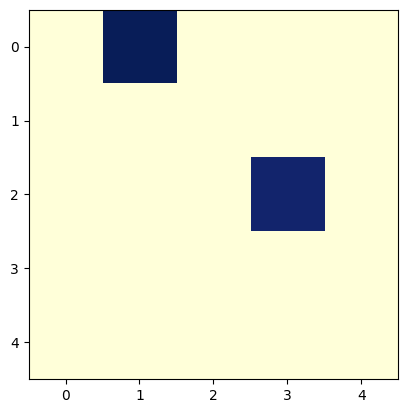

In [274]:
plt.imshow(wil,  cmap="YlGnBu", interpolation='nearest')
plt.show()

In [43]:
labels = ['VGG','ConvNeXt','ResNet','DenseNet','EfficientNet']

In [45]:
wil

[[0,
  0.697782855364494,
  1.1542579159140587e-06,
  4.336470738053322e-07,
  2.2118911147117615e-09],
 [0, 0, 6.239861249923706e-08, 2.4097971618175507e-08, 5.820766091346741e-10],
 [0, 0, 0, 0.8933956801836471, 8.149072527885437e-09],
 [0, 0, 0, 0, 1.1641532182693481e-09],
 [0, 0, 0, 0, 0]]

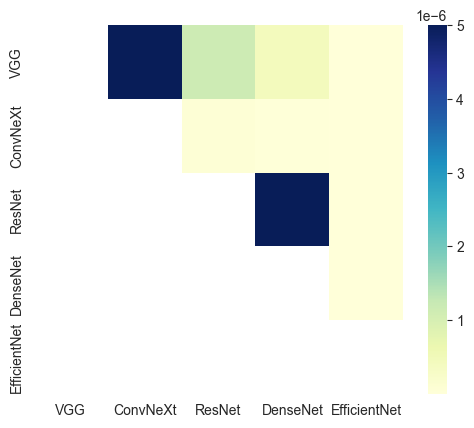

In [48]:
import seaborn as sns
mask = np.zeros_like(wil)
mask[np.tril_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(wil, mask=mask, vmax=.000005, square=True,  cmap="YlGnBu",xticklabels=labels, yticklabels=labels)
    plt.show()

In [291]:
for i, ix in enumerate(ax.dendrogram_row.reordered_ind):
    for j, jx in enumerate(ax.dendrogram_row.reordered_ind):
        if i != j:
            text = ax.ax_heatmap.text(
                j + 0.5,
                i + 0.5,
                "*" if wil[ix, jx]<.05/10 else "",
                ha="center",
                va="center",
                color="black",
            )
            text.set_fontsize(20)

AttributeError: 'AxesSubplot' object has no attribute 'dendrogram_row'

In [283]:
mask

array([[1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.]])

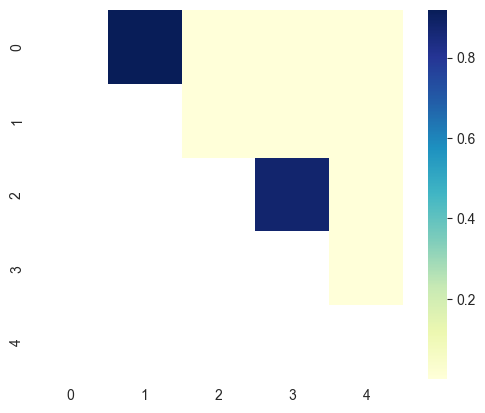

In [285]:
import seaborn as sns
mask = np.zeros_like(wil)
mask[np.tril_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(wil, mask=mask, square=True,  cmap="YlGnBu")
    plt.show()

In [19]:
scanners = {'LightSpeed VCT': ['Pediatric-CT-SEG-050CB44A',
  'Pediatric-CT-SEG-0C78EBBE',
  'Pediatric-CT-SEG-11FCDCBD',
  'Pediatric-CT-SEG-1644392C',
  'Pediatric-CT-SEG-1D20EAD2',
  'Pediatric-CT-SEG-3B5CED31',
  'Pediatric-CT-SEG-491B83F3',
  'Pediatric-CT-SEG-4A25C4F3',
  'Pediatric-CT-SEG-4B20AED7',
  'Pediatric-CT-SEG-51733317',
  'Pediatric-CT-SEG-57A2E054',
  'Pediatric-CT-SEG-59397A22',
  'Pediatric-CT-SEG-66EE3D8A',
  'Pediatric-CT-SEG-769F1A5A',
  'Pediatric-CT-SEG-968A78B3',
  'Pediatric-CT-SEG-AB8F282E',
  'Pediatric-CT-SEG-F0386168',
  'Pediatric-CT-SEG-F50AD62F'],
 'SOMATOM Definition AS+': ['Pediatric-CT-SEG-0C5320A6',
  'Pediatric-CT-SEG-1188A817',
  'Pediatric-CT-SEG-20A9D6EC',
  'Pediatric-CT-SEG-354',
  'Pediatric-CT-SEG-380',
  'Pediatric-CT-SEG-381',
  'Pediatric-CT-SEG-3B10B8AB',
  'Pediatric-CT-SEG-400',
  'Pediatric-CT-SEG-5B1E0A68',
  'Pediatric-CT-SEG-677673CD',
  'Pediatric-CT-SEG-691FB79F',
  'Pediatric-CT-SEG-826600AF',
  'Pediatric-CT-SEG-84CF10F5',
  'Pediatric-CT-SEG-906B8910',
  'Pediatric-CT-SEG-920AD27A',
  'Pediatric-CT-SEG-A768A490'],
 'Revolution CT': ['Pediatric-CT-SEG-3DAE6E6F',
  'Pediatric-CT-SEG-627003CD',
  'Pediatric-CT-SEG-7C205617',
  'Pediatric-CT-SEG-7E9377C4',
  'Pediatric-CT-SEG-AF83DAF1']}

In [20]:
mae_score_df = pd.DataFrame( columns=["model","dataset",
                            "femoral_start","femoral_end",
                            "bladder_start","bladder_end",
                            "liver_start","liver_end",
                            "lung_start","lung_end",
                            "heart_start","heart_end",
                            "stomach_start","stomach_end",
                            "esophagus_start","esophagus_end",
                            "spleen_start","spleen_end",
                            "pancreas_start","pancreas_end",
                            "duodenum_start","duodenum_end",
                            'small_intestine_start','small_intestine_end',
                            'large_intestine_start','large_intestine_end',
                            'rectum_start','rectum_end',
                            'adrenal_start','adrenal_end',
                            'gall_bladder_start','gall_bladder_end',
                            'kidney_start','kidney_end','overall'])
std_score_df = pd.DataFrame( columns=["model","dataset",
                            "femoral_start","femoral_end",
                            "bladder_start","bladder_end",
                            "liver_start","liver_end",
                            "lung_start","lung_end",
                            "heart_start","heart_end",
                            "stomach_start","stomach_end",
                            "esophagus_start","esophagus_end",
                            "spleen_start","spleen_end",
                            "pancreas_start","pancreas_end",
                            "duodenum_start","duodenum_end",
                            'small_intestine_start','small_intestine_end',
                            'large_intestine_start','large_intestine_end',
                            'rectum_start','rectum_end',
                            'adrenal_start','adrenal_end',
                            'gall_bladder_start','gall_bladder_end',
                            'kidney_start','kidney_end','overall'])
model = "efficientnet"
result_path = "SSBRresults\\json\\efficientnet\\test\\"
dic ={}

model_summary = gen_summary(model)


C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  post_score_df = post_score_df.append(score_row,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2714044739.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

In [21]:
for scanner in scanners:
    for sub in scanners[scanner]:
      f = open(result_path+sub+"_img.json")
      name = sub+"_img"
      data = json.load(f)
      scores = data['post_scores']
      for landmark in mae_score_df.columns[2:-1]:
        start_mean = model_summary[landmark]["mean"]
        pred =find_nearest(scores,start_mean)
        real=landmark_df.loc[landmark_df['filename'] == name.split(".")[0]][landmark].values[0]
        if real==-1 or name in bad_labels:
          continue
        factor = 100/len(scores)
        scaled_pred = pred*factor
        scaled_real = real*factor
        mse_score = abs(scaled_pred-scaled_real)
        if landmark not in dic:
          dic[landmark] = []
        dic[landmark].append(mse_score)
        if mse_score>1000 and model == 'efficientnet':
          print(name,landmark,mse_score,scaled_pred,scaled_real,len(scores))
    mean_dic = {}
    std_dic = {}
    overall_error=[]
    for key,value in dic.items():
      #mean_dic[key] = sum(value)/len(value)
      mean_dic[key] = statistics.mean(value)
      std_dic[key] =statistics.stdev(value)
      overall_error = overall_error+value
      
    mean_dic['overall'] = statistics.mean(overall_error)
    mean_dic["model"] = scanner
    mean_dic["dataset"] = dataset

    std_dic['overall'] = statistics.stdev(overall_error)
    std_dic["model"] = model
    std_dic["dataset"] = dataset
    mae_score_df = mae_score_df.append(mean_dic,ignore_index=True)
    std_score_df = std_score_df.append(std_dic,ignore_index=True)

C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2667057540.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mae_score_df = mae_score_df.append(mean_dic,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2667057540.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  std_score_df = std_score_df.append(std_dic,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2667057540.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mae_score_df = mae_score_df.append(mean_dic,ignore_index=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_32932\2667057540.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

In [34]:
from scipy.stats import wilcoxon
wilcoxon(mae_score_df[mae_score_df["model"]=="LightSpeed VCT"].values[0][2:],mae_score_df[mae_score_df["model"]=="SOMATOM Definition AS+"].values[0][2:])

WilcoxonResult(statistic=280.0, pvalue=1.0)

In [35]:
from scipy.stats import wilcoxon
wilcoxon(mae_score_df[mae_score_df["model"]=="LightSpeed VCT"].values[0][2:],mae_score_df[mae_score_df["model"]=="Revolution CT"].values[0][2:])

WilcoxonResult(statistic=255.0, pvalue=0.6591820653993636)

In [36]:
from scipy.stats import wilcoxon
wilcoxon(mae_score_df[mae_score_df["model"]=="SOMATOM Definition AS+"].values[0][2:],mae_score_df[mae_score_df["model"]=="Revolution CT"].values[0][2:])

WilcoxonResult(statistic=247.0, pvalue=0.5601940555498004)

In [31]:
mae_score_df[mae_score_df["model"]=="LightSpeed VCT"].values[0][2:]

array([1.3513453262531527, 1.4947038746640204, 1.7849671017200643,
       5.299099550371661, 3.287039998012706, 1.2757823887812125,
       2.2171535509335984, 8.453821104035843, 1.9230686303249651,
       3.5228806232931382, 4.062433733592816, 1.2171230484797084,
       2.568919540903931, 11.499926708963448, 4.647325432616572,
       1.0069380362724765, 3.0201148475040904, 2.9824639707221077,
       4.1694783750889375, 2.2666612564219237, 2.5637722124000635,
       4.067138864547398, 2.357239996285388, 4.618650434080251,
       2.7935701843085243, 2.067498646409697, 3.1235382269116365,
       2.788135283069484, 3.2317137437372483, 1.9626215402125378,
       3.5255760402842293, 2.9876270710634074, 3.25432279194582],
      dtype=object)

In [32]:
mae_score_df[mae_score_df["model"]=="SOMATOM Definition AS+"].values[0][2:]

array([1.827289639111593, 1.3315953253785626, 2.20518672271022,
       5.266689074734464, 4.027693814460635, 1.5322527650965294,
       1.8339118092764048, 6.8083710015838275, 1.7014404899056785,
       2.5825732682263594, 4.797034780399189, 1.4835851157399071,
       1.9232900970159577, 9.203668173226957, 4.912391022222312,
       1.4337372983965713, 3.5812816600972606, 2.2329408705726275,
       4.329647279262546, 2.136793884232172, 3.6026608340724526,
       3.4685797744871945, 2.7232197165738485, 4.136267965170078,
       2.787864330740232, 2.245646058750226, 3.391761456326528,
       2.2133372228493964, 3.8610128628940124, 2.238626849346585,
       3.906430774421169, 2.3061339707227884, 3.188528622125134],
      dtype=object)

In [33]:
mae_score_df[mae_score_df["model"]=="Revolution CT"].values[0][2:]

array([1.9068041096374693, 1.3854692408667832, 2.253201491462412,
       5.286369133794106, 4.339772455030648, 1.8520869606886237,
       1.850236834940246, 6.007386177868083, 1.8013122209697394,
       2.278741119023258, 4.7686333998606205, 1.4995874171726626,
       2.0453297426512504, 8.120883682259079, 4.81003822651383,
       1.3562670732458433, 3.3375373541324085, 2.171572231088981,
       4.291328270984475, 2.282995305425257, 3.6061443898685304,
       3.4464694362553696, 2.78877420778329, 4.564656632463166,
       2.707876611109054, 2.537792046855684, 3.248450939491326,
       2.1779614180566127, 4.312611622290713, 2.4701085825809637,
       4.083965639692679, 2.2402131036960196, 3.1822055336799746],
      dtype=object)

In [22]:
mae_score_df

,model,dataset,femoral_start,femoral_end,bladder_start,bladder_end,liver_start,liver_end,lung_start,lung_end,...,large_intestine_end,rectum_start,rectum_end,adrenal_start,adrenal_end,gall_bladder_start,gall_bladder_end,kidney_start,kidney_end,overall
0,LightSpeed VCT,test,1.351345,1.494704,1.784967,5.299100,3.287040,1.275782,2.217154,8.453821,...,4.618650,2.793570,2.067499,3.123538,2.788135,3.231714,1.962622,3.525576,2.987627,3.254323
1,SOMATOM Definition AS+,test,1.827290,1.331595,2.205187,5.266689,4.027694,1.532253,1.833912,6.808371,...,4.136268,2.787864,2.245646,3.391761,2.213337,3.861013,2.238627,3.906431,2.306134,3.188529
2,Revolution CT,test,1.906804,1.385469,2.253201,5.286369,4.339772,1.852087,1.850237,6.007386,...,4.564657,2.707877,2.537792,3.248451,2.177961,4.312612,2.470109,4.083966,2.240213,3.182206


In [62]:
dic

{}

In [1]:
mean_dic[key]

NameError: name 'mean_dic' is not defined

In [62]:
wilcoxon([0.868040741,
          0.875325926,
          0.800896296,
          0.722514815,
          0.967977778,	
          0.855085185,	
          0.934811111,	
          0.715840741,	
          0.532088889,	
          0.361877778,	
          0.856396296,	
          0.9598	,
          0.938592593,	
          0.965596296,
          0.951792593,
          0.925644444,	
          0.675674074,
          0.798366667,
          0.799625926,
          0.623166667
]
    
    ,[0.931118519,
      0.928525926,
      0.845877778,
      0.796462963,
      0.97237037,
      0.900759259,	
      0.952077778,	
      0.755344444,	
      0.604022222,
      0.542725926,
      0.882833333,	
      0.962055556,	
      0.958640741,	
      0.971533333,	
      0.957292593,	
      0.942918519,
      0.753425926,
      0.826044444,	
      0.807862963,
      0.63532963,

])

WilcoxonResult(statistic=0.0, pvalue=1.9073486328125e-06)